In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sbn
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, roc_auc_score, classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from joblib import dump

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Прогнозирование сердечно-сосудистых заболеваний

На основе предоставленных данных спрогнозировать риск сердечно-сосудистых заболеваний (ССЗ):
* age - возраст (дней с рождения)
* gender - пол
* height - рост
* weight - вес
* ap_hi - верхнее давление
* ap_lo - нижнее давление
* cholesterol - холестерин
* gluc - глюкоза
* smoke - курит или нет
* alco - злоупотребляет алкоголем
* active - ведёт активных образ жизни
* cardio - признак наличия сердечных заболеваний

Метрика для оценки качества **ROC-AUC** по целевому признаку **cardio**

In [2]:
df_train = pd.read_csv('train.csv',index_col=0)
df_train['is_train'] = 1
df_train.head()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,is_train
id,,,,,,,,,,,,,
0,18393,2,168,62.0,110,80,1,1,0,0,1,0,1
1,20228,1,156,85.0,140,90,3,1,0,0,1,1,1
2,18857,1,165,64.0,130,70,3,1,0,0,0,1,1
3,17623,2,169,82.0,150,100,1,1,0,0,1,1,1
4,17474,1,156,56.0,100,60,1,1,0,0,0,0,1


In [3]:
print(df_train.duplicated().sum())
df_train = df_train.drop_duplicates()

24


In [4]:
df_test = pd.read_csv('test.csv',index_col=0)
df_test['is_train'] = 0
df_test.head()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,is_train
id,,,,,,,,,,,,
5,18888,1,154,85.0,130,80,1,1,0,0,1,0
6,19042,2,170,69.0,130,90,1,1,0,0,1,0
7,20432,1,160,70.0,120,75,1,1,0,0,0,0
10,18133,2,185,94.0,130,90,1,1,0,0,1,0
11,16093,2,170,76.0,120,80,1,1,0,0,1,0


In [5]:
# объеденим два файла и "почистим"
df = pd.concat([df_train, df_test])

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99976 entries, 0 to 99997
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   age          99976 non-null  int64  
 1   gender       99976 non-null  int64  
 2   height       99976 non-null  int64  
 3   weight       99976 non-null  float64
 4   ap_hi        99976 non-null  int64  
 5   ap_lo        99976 non-null  int64  
 6   cholesterol  99976 non-null  int64  
 7   gluc         99976 non-null  int64  
 8   smoke        99976 non-null  int64  
 9   alco         99976 non-null  int64  
 10  active       99976 non-null  int64  
 11  cardio       69976 non-null  float64
 12  is_train     99976 non-null  int64  
dtypes: float64(2), int64(11)
memory usage: 10.7 MB


In [7]:
df.isna().sum()

age                0
gender             0
height             0
weight             0
ap_hi              0
ap_lo              0
cholesterol        0
gluc               0
smoke              0
alco               0
active             0
cardio         30000
is_train           0
dtype: int64

In [8]:
# для себя переименую переменные, чтобы легче было отличать бинарные от других типов
df = df.rename(columns={'gender': 'is_male', 'alco': 'is_alco', 'smoke': 'is_smoke', 'active': 'is_active', 'cardio': 'is_cardio'})

In [9]:
df['is_male'] = df['is_male'].map({1: 0, 2: 1})

In [10]:
df['age'] = df['age'] / 365.25
df['age'] = df['age'].astype(int)

## Анализ данных

In [11]:
df.describe()

,age,is_male,height,weight,ap_hi,ap_lo,cholesterol,gluc,is_smoke,is_alco,is_active,is_cardio,is_train
count,99976.000000,99976.000000,99976.000000,99976.000000,99976.000000,99976.000000,99976.000000,99976.000000,99976.000000,99976.000000,99976.000000,69976.000000,99976.000000
mean,52.792310,0.350874,164.348084,74.182141,129.255811,96.352014,1.367308,1.225384,0.088291,0.054153,0.804323,0.499771,0.699928
std,6.770735,0.477246,8.211951,14.380513,173.660460,181.458960,0.679980,0.570601,0.283719,0.226320,0.396723,0.500004,0.458291
min,24.000000,0.000000,50.000000,10.000000,-150.000000,-90.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,48.000000,0.000000,159.000000,65.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000
50%,53.000000,0.000000,165.000000,72.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000
75%,58.000000,1.000000,170.000000,82.000000,140.000000,90.000000,2.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000
max,64.000000,1.000000,250.000000,200.000000,16020.000000,11000.000000,3.000000,3.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Выявлены следующие замечания:
* в значения роста и веса есть аномально большие и маленькие значения;
* в показателях артериального давления, есть отрицательные значения и аномально большие значения.

### Аномалии и выбросы

Нормализуем данные у данных полей:

* height
* weight
* ap_hi
* ap_lo

#### height и weight

Для анализа роста и веса добавим ИМТ (индекс массы тела)

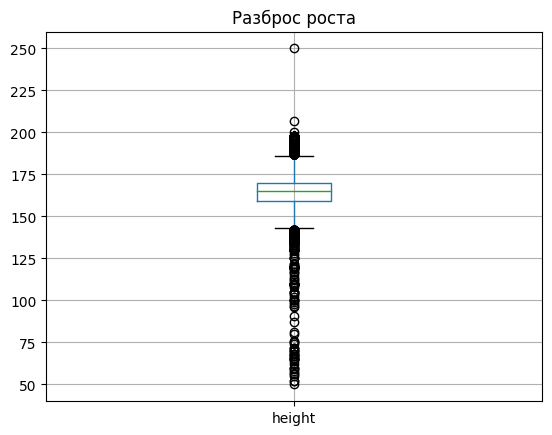

In [12]:
df.boxplot('height')
plt.title('Разброс роста')
plt.show()

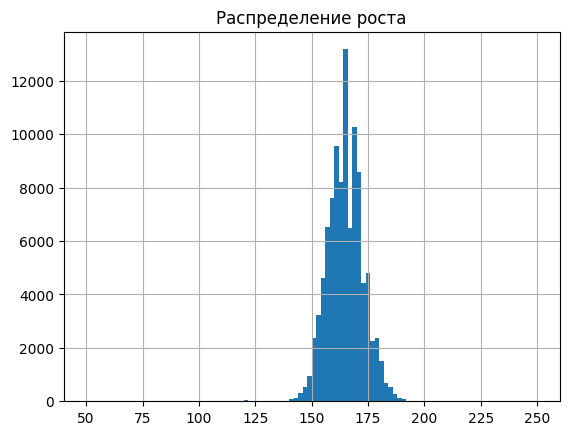

In [13]:
df['height'].hist(bins=100)
plt.title('Распределение роста')
plt.show()

In [14]:
# удалим аномально высокий рост с весом 86
big_height = df[df['height'] > 240]
display(big_height.head())
df.drop(big_height.index, inplace=True)
del big_height

,age,is_male,height,weight,ap_hi,ap_lo,cholesterol,gluc,is_smoke,is_alco,is_active,is_cardio,is_train
id,,,,,,,,,,,,,
9223,58,0,250,86.0,140,100,3,1,0,0,1,1.0,1


In [15]:
# проверим тех у кого рост ниже 100
little_height = df[df['height'] < 100]
display(little_height.head(10))
print(little_height.shape)

,age,is_male,height,weight,ap_hi,ap_lo,cholesterol,gluc,is_smoke,is_alco,is_active,is_cardio,is_train
id,,,,,,,,,,,,,
309,59,1,76,55.0,120,80,1,1,0,0,1,0.0,1
10843,40,1,70,72.0,120,8,1,1,0,0,1,0.0,1
11662,48,1,97,170.0,160,100,1,1,1,0,1,1.0,1
18218,53,0,75,168.0,120,80,1,1,1,0,1,1.0,1
18928,61,1,71,68.0,120,80,3,1,0,0,1,0.0,1
20459,60,0,67,57.0,120,90,1,1,0,0,1,1.0,1
21686,43,0,70,68.0,120,80,1,1,0,0,0,0.0,1
23859,53,1,74,98.0,140,90,1,1,0,0,1,1.0,1
24690,47,0,98,45.0,12,80,1,1,0,0,1,0.0,1


(41, 13)


Найдены слишком "маленькие люди", но с большим весом, возможно перепутали рост и вес. Исправим это.

In [16]:
def height_weight(row):
    """
    Нормализуем значения в полях рост и вес
    
    Параметры:
    ----------
    row: Series
    
    Результат:
    ----------
    Обновлённая строка
    """
    
    if row['height'] < 100 and row['weight'] > 100:
        height = row['weight']
        weight = row['height']
        
        row['height'] = height
        row['weight'] = weight
        
    return row

df = df.apply(height_weight, axis=1)

In [17]:
# проверяем замену
df.loc[little_height.index].head()

,age,is_male,height,weight,ap_hi,ap_lo,cholesterol,gluc,is_smoke,is_alco,is_active,is_cardio,is_train
id,,,,,,,,,,,,,
309,59.0,1.0,76.0,55.0,120.0,80.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0
10843,40.0,1.0,70.0,72.0,120.0,8.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0
11662,48.0,1.0,170.0,97.0,160.0,100.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0
18218,53.0,0.0,168.0,75.0,120.0,80.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0
18928,61.0,1.0,71.0,68.0,120.0,80.0,3.0,1.0,0.0,0.0,1.0,0.0,1.0


Аналогично проверим вес

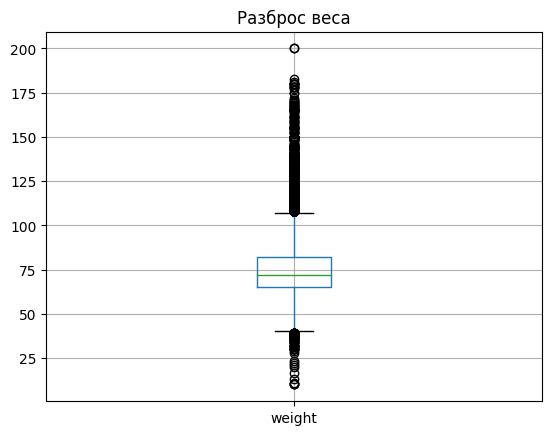

In [18]:
df.boxplot('weight')
plt.title('Разброс веса')
plt.show()

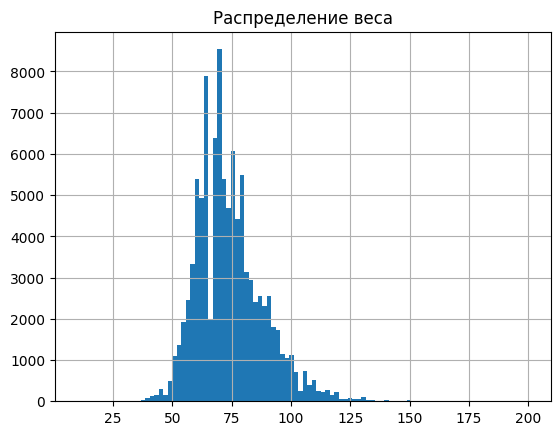

In [19]:
df['weight'].hist(bins=100)
plt.title('Распределение веса')
plt.show()

In [20]:
# проверим аномально полных и худых
display(df[df['weight'] > 180])

,age,is_male,height,weight,ap_hi,ap_lo,cholesterol,gluc,is_smoke,is_alco,is_active,is_cardio,is_train
id,,,,,,,,,,,,,
618,45.0,0.0,186.0,200.0,130.0,70.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0
52564,53.0,0.0,161.0,181.0,180.0,1100.0,2.0,1.0,0.0,0.0,1.0,1.0,1.0
71945,41.0,1.0,180.0,200.0,150.0,90.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0
87498,57.0,1.0,180.0,183.0,110.0,80.0,3.0,3.0,0.0,1.0,1.0,1.0,1.0


Показатели вполне допустимы

In [21]:
little_weight = df[df['weight'] <= 30]
display(little_weight.head())
# удалить выбросы не получиться, но по пробуем привести их к среднему значению
df.loc[little_weight.index, 'weight'] = None

,age,is_male,height,weight,ap_hi,ap_lo,cholesterol,gluc,is_smoke,is_alco,is_active,is_cardio,is_train
id,,,,,,,,,,,,,
5306,42.0,0.0,120.0,30.0,110.0,70.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0
26503,49.0,0.0,160.0,30.0,120.0,80.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0
38312,63.0,0.0,157.0,23.0,110.0,80.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0
42156,55.0,1.0,177.0,22.0,120.0,80.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0
48318,59.0,1.0,178.0,11.0,130.0,90.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0


Заполним созданные пропуски

In [22]:
# Заполним пропуск медианным начением
df['weight'] = df['weight'].fillna(df.loc[df['is_train'] == 1, 'weight'].median())

display(df.loc[little_weight.index].head())

little_weight = None

,age,is_male,height,weight,ap_hi,ap_lo,cholesterol,gluc,is_smoke,is_alco,is_active,is_cardio,is_train
id,,,,,,,,,,,,,
5306,42.0,0.0,120.0,72.0,110.0,70.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0
26503,49.0,0.0,160.0,72.0,120.0,80.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0
38312,63.0,0.0,157.0,72.0,110.0,80.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0
42156,55.0,1.0,177.0,72.0,120.0,80.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0
48318,59.0,1.0,178.0,72.0,130.0,90.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0


In [23]:
df.isna().sum()

age                0
is_male            0
height             0
weight             0
ap_hi              0
ap_lo              0
cholesterol        0
gluc               0
is_smoke           0
is_alco            0
is_active          0
is_cardio      30000
is_train           0
dtype: int64

#### AP_HI и AP_LO - давление

Есть аномально большие значения. Смертельным считается 260 на 100 и 60 на 40 будем исходить из этого

In [24]:
# начнём с отрицательных значений
df['ap_hi'] = df['ap_hi'].abs()
df['ap_lo'] = df['ap_lo'].abs()

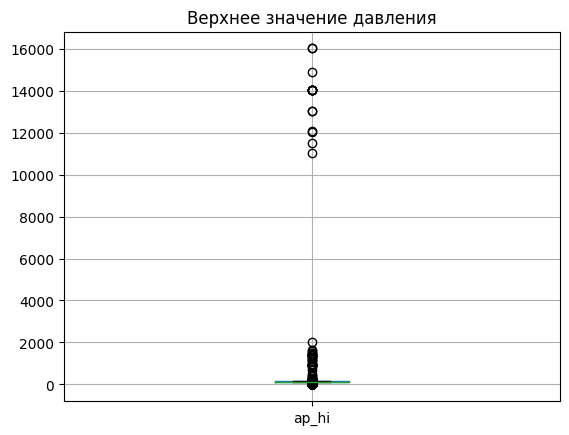

In [25]:
df.boxplot('ap_hi')
plt.title('Верхнее значение давления')
plt.show()

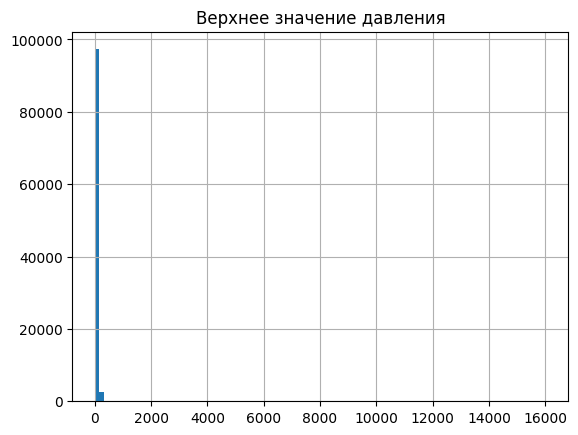

In [26]:
df['ap_hi'].hist(bins=100)
plt.title('Верхнее значение давления')
plt.show()

In [27]:
# разбираемся с аномально высокими значениями
big_app_hi = df[df['ap_hi'] > 800]
display(big_app_hi.sort_values('ap_hi').head())
print(big_app_hi.shape)

,age,is_male,height,weight,ap_hi,ap_lo,cholesterol,gluc,is_smoke,is_alco,is_active,is_cardio,is_train
id,,,,,,,,,,,,,
59301,57.0,0.0,154.0,41.0,806.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0
2654,41.0,0.0,160.0,60.0,902.0,60.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0
30877,43.0,1.0,180.0,70.0,906.0,60.0,1.0,1.0,0.0,0.0,1.0,NaN,0.0
24871,56.0,0.0,168.0,56.0,906.0,60.0,2.0,1.0,0.0,0.0,1.0,NaN,0.0
98095,49.0,0.0,156.0,41.0,906.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0


(54, 13)


In [28]:
def ap_hi(row):
    """
    Нормализуем значения в давлении
    
    Параметры:
    ----------
    row: Series
    
    Результат:
    ----------
    Обновлённая строка
    """
    
    if row['ap_hi'] > 250 and row['ap_hi'] <= 2000:
        ap_hi = int(row['ap_hi'] / 10)
        row['ap_hi'] = ap_hi
    elif row['ap_hi'] > 2000:
        ap_hi = int(row['ap_hi'] / 100)
        row['ap_hi'] = ap_hi
        
    return row

df = df.apply(ap_hi, axis=1)

In [29]:
df.loc[big_app_hi.index].head()
big_app_hi = None

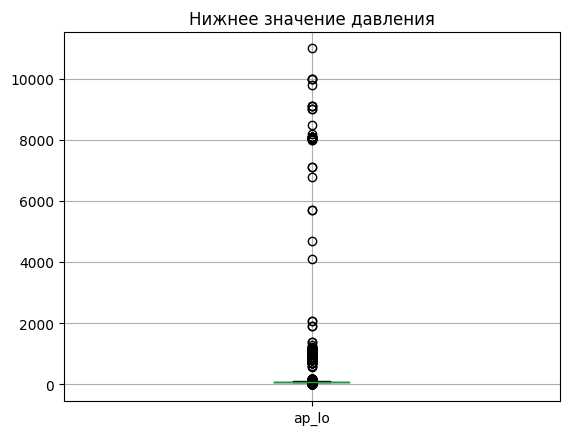

In [30]:
df.boxplot('ap_lo')
plt.title('Нижнее значение давления')
plt.show()

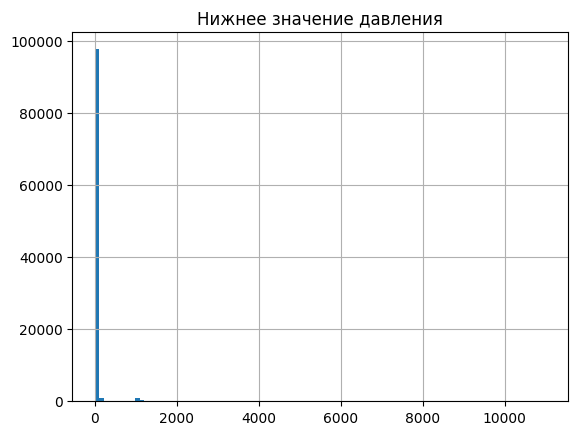

In [31]:
df['ap_lo'].hist(bins=100)
plt.title('Нижнее значение давления')
plt.show()

In [32]:
# разбираемся с аномально высокими значениями
big_app_lo = df[df['ap_lo'] > 500]
display(big_app_lo.sort_values('ap_lo').head())
print(big_app_lo.shape)

,age,is_male,height,weight,ap_hi,ap_lo,cholesterol,gluc,is_smoke,is_alco,is_active,is_cardio,is_train
id,,,,,,,,,,,,,
97818,39.0,0.0,163.0,83.0,11.0,570.0,1.0,1.0,0.0,0.0,1.0,NaN,0.0
91933,57.0,1.0,173.0,94.0,13.0,585.0,2.0,1.0,0.0,0.0,1.0,1.0,1.0
99006,57.0,1.0,168.0,63.0,120.0,602.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0
80714,64.0,1.0,168.0,74.0,130.0,700.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0
60834,51.0,0.0,165.0,65.0,110.0,701.0,1.0,1.0,0.0,0.0,1.0,NaN,0.0


(1355, 13)


In [33]:
def ap_lo(row):
    """
    Нормализуем значения в давлении
    
    Параметры:
    ----------
    row: Series
    
    Результат:
    ----------
    Обновлённая строка
    """
    
    if row['ap_lo'] > 500 and row['ap_lo'] <= 2000:
        ap_lo = int(row['ap_lo'] / 10)
        row['ap_lo'] = ap_lo
    elif row['ap_lo'] > 2000:
        ap_lo = int(row['ap_lo'] / 100)
        row['ap_lo'] = ap_lo
        
    return row

df = df.apply(ap_lo, axis=1)

In [34]:
display(df.loc[big_app_lo.index].head())
big_app_lo = None

,age,is_male,height,weight,ap_hi,ap_lo,cholesterol,gluc,is_smoke,is_alco,is_active,is_cardio,is_train
id,,,,,,,,,,,,,
314,47.0,1.0,183.0,98.0,160.0,110.0,1.0,2.0,1.0,0.0,1.0,1.0,1.0
334,60.0,1.0,157.0,60.0,160.0,100.0,2.0,1.0,0.0,0.0,0.0,1.0,1.0
357,49.0,0.0,150.0,83.0,140.0,80.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0
458,64.0,0.0,176.0,63.0,160.0,100.0,2.0,2.0,0.0,0.0,0.0,1.0,1.0
482,51.0,0.0,154.0,81.0,140.0,100.0,2.0,1.0,0.0,0.0,1.0,1.0,1.0


In [35]:
ap_warn = df[df['ap_hi'] < df['ap_lo']]
# теперь разберёмся с ситуацией, когда ap_hi < ap_lo
display(ap_warn.head())
print(ap_warn.shape)

,age,is_male,height,weight,ap_hi,ap_lo,cholesterol,gluc,is_smoke,is_alco,is_active,is_cardio,is_train
id,,,,,,,,,,,,,
681,52.0,0.0,156.0,65.0,120.0,150.0,2.0,1.0,0.0,0.0,1.0,0.0,1.0
815,58.0,0.0,168.0,78.0,14.0,90.0,2.0,1.0,0.0,0.0,1.0,1.0,1.0
913,56.0,1.0,169.0,68.0,70.0,110.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0
1294,59.0,1.0,175.0,70.0,14.0,90.0,3.0,1.0,0.0,0.0,1.0,1.0,1.0
1360,49.0,0.0,172.0,65.0,11.0,80.0,1.0,3.0,0.0,0.0,1.0,0.0,1.0


(407, 13)


In [36]:
def ap_mv(row):
    """
    Поменяем местами давление
    
    Параметры:
    ----------
    row: Series
    
    Результат:
    ----------
    Обновлённая строка
    """
    
    if row['ap_hi'] < row['ap_lo'] and row['ap_lo'] > 90:
        ap_lo = row['ap_lo']
        ap_hi = row['ap_hi']
        
        row['ap_hi'] = ap_lo
        row['ap_lo'] = ap_hi
        
    return row

df = df.apply(ap_mv, axis=1)

In [37]:
display(df.loc[ap_warn.index].head())
ap_warn = None

,age,is_male,height,weight,ap_hi,ap_lo,cholesterol,gluc,is_smoke,is_alco,is_active,is_cardio,is_train
id,,,,,,,,,,,,,
681,52.0,0.0,156.0,65.0,150.0,120.0,2.0,1.0,0.0,0.0,1.0,0.0,1.0
815,58.0,0.0,168.0,78.0,14.0,90.0,2.0,1.0,0.0,0.0,1.0,1.0,1.0
913,56.0,1.0,169.0,68.0,110.0,70.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0
1294,59.0,1.0,175.0,70.0,14.0,90.0,3.0,1.0,0.0,0.0,1.0,1.0,1.0
1360,49.0,0.0,172.0,65.0,11.0,80.0,1.0,3.0,0.0,0.0,1.0,0.0,1.0


In [38]:
# теперь разберёмся с предтрупными значениями
dead_ap = df[(df['ap_hi'] < 60) | (df['ap_lo'] < 40)]
display(dead_ap.sort_values('ap_hi').head())

print(dead_ap.shape)

,age,is_male,height,weight,ap_hi,ap_lo,cholesterol,gluc,is_smoke,is_alco,is_active,is_cardio,is_train
id,,,,,,,,,,,,,
12494,46.0,1.0,163.0,63.0,1.0,20.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0
42755,52.0,0.0,158.0,61.0,1.0,30.0,1.0,1.0,0.0,0.0,1.0,NaN,0.0
51749,50.0,0.0,169.0,62.0,1.0,20.0,1.0,1.0,0.0,0.0,1.0,NaN,0.0
7657,58.0,0.0,162.0,69.0,7.0,80.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0
43735,63.0,1.0,184.0,88.0,10.0,0.0,3.0,1.0,0.0,0.0,0.0,NaN,0.0


(339, 13)


In [39]:
# применим самый простой способ
df.loc[dead_ap.index, 'ap_hi'] = None
df.loc[dead_ap.index, 'ap_lo'] = None

df['ap_hi'] = df['ap_hi'].fillna(df.loc[df['is_train'] == 1, 'ap_hi'].median())
df['ap_lo'] = df['ap_lo'].fillna(df.loc[df['is_train'] == 1, 'ap_lo'].median())

display(df.loc[dead_ap.index].head())

dead_ap = None

,age,is_male,height,weight,ap_hi,ap_lo,cholesterol,gluc,is_smoke,is_alco,is_active,is_cardio,is_train
id,,,,,,,,,,,,,
594,45.0,0.0,157.0,72.0,120.0,80.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0
815,58.0,0.0,168.0,78.0,120.0,80.0,2.0,1.0,0.0,0.0,1.0,1.0,1.0
1294,59.0,1.0,175.0,70.0,120.0,80.0,3.0,1.0,0.0,0.0,1.0,1.0,1.0
1360,49.0,0.0,172.0,65.0,120.0,80.0,1.0,3.0,0.0,0.0,1.0,0.0,1.0
2260,52.0,0.0,165.0,66.0,120.0,80.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0


In [40]:
df.isna().sum()

age                0
is_male            0
height             0
weight             0
ap_hi              0
ap_lo              0
cholesterol        0
gluc               0
is_smoke           0
is_alco            0
is_active          0
is_cardio      30000
is_train           0
dtype: int64

Нормализация данных завершена, приступим графическому анализу

### Анализ

In [41]:
df.corr()

,age,is_male,height,weight,ap_hi,ap_lo,cholesterol,gluc,is_smoke,is_alco,is_active,is_cardio,is_train
age,1.000000,-0.021185,-0.081856,0.058036,0.208702,0.156866,0.154209,0.099560,-0.045349,-0.029624,-0.011295,0.237973,0.002514
is_male,-0.021185,1.000000,0.501090,0.160227,0.063573,0.071954,-0.034190,-0.017019,0.336989,0.168762,0.008359,0.008048,-0.003918
height,-0.081856,0.501090,1.000000,0.299928,0.016901,0.034675,-0.051879,-0.017768,0.188279,0.094800,-0.008102,-0.010730,0.001699
weight,0.058036,0.160227,0.299928,1.000000,0.271720,0.256400,0.140122,0.106405,0.068405,0.067729,-0.018881,0.181818,0.002798
ap_hi,0.208702,0.063573,0.016901,0.271720,1.000000,0.743850,0.194903,0.092851,0.029332,0.035648,0.000648,0.431010,-0.000741
ap_lo,0.156866,0.071954,0.034675,0.256400,0.743850,1.000000,0.162265,0.073974,0.028229,0.036817,-0.000839,0.346565,-0.001822
cholesterol,0.154209,-0.034190,-0.051879,0.140122,0.194903,0.162265,1.000000,0.447804,0.012647,0.031815,0.010654,0.221096,-0.000714
gluc,0.099560,-0.017019,-0.017768,0.106405,0.092851,0.073974,0.447804,1.000000,-0.002192,0.008269,-0.006132,0.089275,0.003083
is_smoke,-0.045349,0.336989,0.188279,0.068405,0.029332,0.028229,0.012647,-0.002192,1.000000,0.334913,0.029437,-0.015529,-0.000711
is_alco,-0.029624,0.168762,0.094800,0.067729,0.035648,0.036817,0.031815,0.008269,0.334913,1.000000,0.024108,-0.007362,-0.002449


In [42]:
cols_to_optimize = {
    'age': 'int8',
    'is_male': 'int8',
    'height': 'int16',
    'weight': 'int16',
    'ap_hi': 'int16',
    'ap_lo': 'int16',
    'cholesterol': 'int8',
    'gluc': 'int8',
    'is_smoke': 'int8',
    'is_alco': 'int8',
    'is_cardio': 'float32',
    'is_train': 'int8',
    'is_active': 'int8'
}

for col, dtype in cols_to_optimize.items():
    df[col] = df[col].astype(dtype)

In [43]:
df.describe()

,age,is_male,height,weight,ap_hi,ap_lo,cholesterol,gluc,is_smoke,is_alco,is_active,is_cardio,is_train
count,99975.000000,99975.000000,99975.000000,99975.000000,99975.000000,99975.000000,99975.000000,99975.000000,99975.000000,99975.000000,99975.000000,69975.000000,99975.000000
mean,52.792258,0.350878,164.353678,74.182836,127.055194,81.595789,1.367292,1.225386,0.088292,0.054154,0.804321,0.499764,0.699925
std,6.770749,0.477247,8.174581,14.342089,16.990534,9.697500,0.679964,0.570603,0.283721,0.226322,0.396724,0.500004,0.458293
min,24.000000,0.000000,50.000000,31.000000,60.000000,40.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,48.000000,0.000000,159.000000,65.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000
50%,53.000000,0.000000,165.000000,72.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000
75%,58.000000,1.000000,170.000000,82.000000,140.000000,90.000000,2.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000
max,64.000000,1.000000,207.000000,200.000000,240.000000,182.000000,3.000000,3.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [44]:
# для анализа введём новую колонку is_healthy - противоположность is_cardio
df.loc[df['is_cardio'] == 1.0, 'is_healthy'] = 0.0
df.loc[df['is_cardio'] == 0.0, 'is_healthy'] = 1.0
df['is_healthy'] = df['is_healthy'].astype('float32')

In [45]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99975 entries, 0 to 99997
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   age          99975 non-null  int8   
 1   is_male      99975 non-null  int8   
 2   height       99975 non-null  int16  
 3   weight       99975 non-null  int16  
 4   ap_hi        99975 non-null  int16  
 5   ap_lo        99975 non-null  int16  
 6   cholesterol  99975 non-null  int8   
 7   gluc         99975 non-null  int8   
 8   is_smoke     99975 non-null  int8   
 9   is_alco      99975 non-null  int8   
 10  is_active    99975 non-null  int8   
 11  is_cardio    69975 non-null  float32
 12  is_train     99975 non-null  int8   
 13  is_healthy   69975 non-null  float32
dtypes: float32(2), int16(4), int8(8)
memory usage: 5.1 MB


In [46]:
# создадим вспомагательные функции для построения графиков
def graf_hist(df, column, column_title='', figsize=(20,5)):
    """
    Построение гистограммы распределения
    
    Параметры:
    ----------
    df: DataFrame - данные
    column: String - колонка для анализа
    column_title: String - пользовательское имя колонки
    figsize: turtle - размер
    """
    fig = plt.figure(figsize = figsize)
    ax = fig.gca()
    
    if column_title == '':
        column_title = column
    df[column].hist(bins=100, ax=ax)
    
    plt.title(f'Распределение столбца - {column_title}')
    plt.ylabel('Количество')
    plt.xlabel(column_title)
    plt.xticks(rotation=90)
    plt.show()
    
def graf_bar(df, column, column_title=''):
    """
    Построение графика для определения распределения пола в долях
    
    Параметры:
    ----------
    df: DataFrame - данные
    column: String - колонка для анализа
    column_title: String - пользовательское имя колонки
    """
    if column_title == '':
        column_title = column
        
    fig = plt.figure(figsize = (20,5))
    ax = fig.gca()
    df.pivot_table(index=[column], values=['is_healthy', 'is_cardio'], aggfunc='sum') \
        .apply(lambda x: x * 100 / sum(x), axis=1) \
        .plot(kind="bar", ax=ax, stacked=True, grid=True).legend(
            loc='upper center', ncol=3, title="Признак здоровья"
        )

    plt.title(f'Распределение столбца - {column_title}')
    plt.ylabel('Доля')
    plt.xlabel(column_title)
    plt.xticks(rotation=90)
    plt.show()

#### age

In [47]:
df.isna().sum()

age                0
is_male            0
height             0
weight             0
ap_hi              0
ap_lo              0
cholesterol        0
gluc               0
is_smoke           0
is_alco            0
is_active          0
is_cardio      30000
is_train           0
is_healthy     30000
dtype: int64

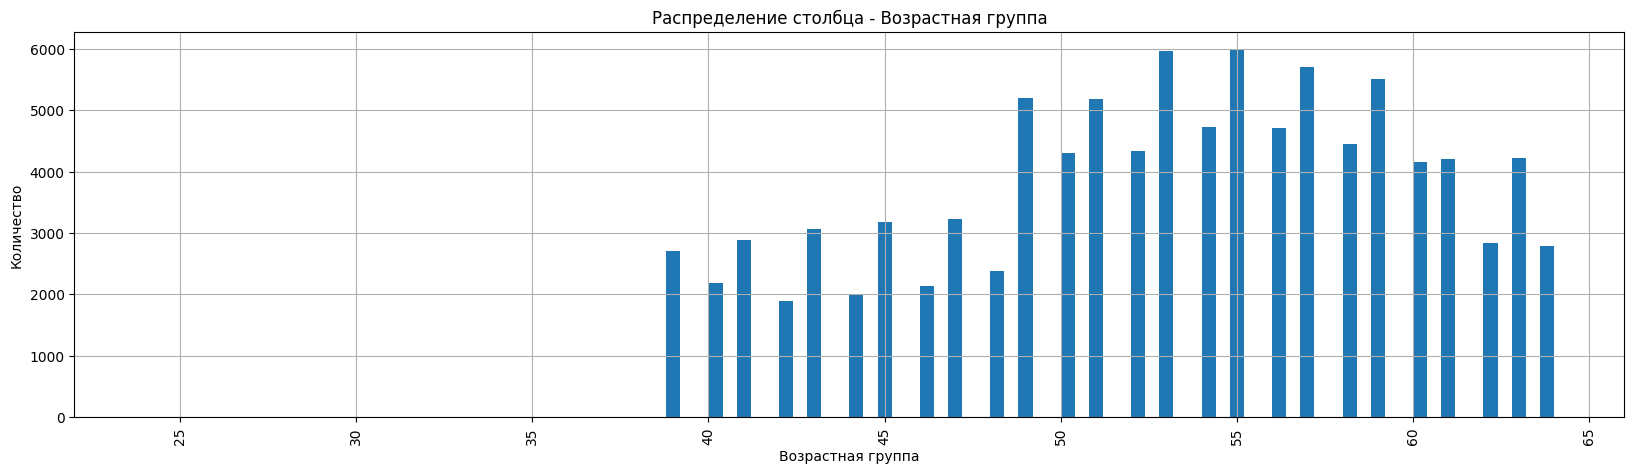

In [48]:
graf_hist(df, 'age', 'Возрастная группа')

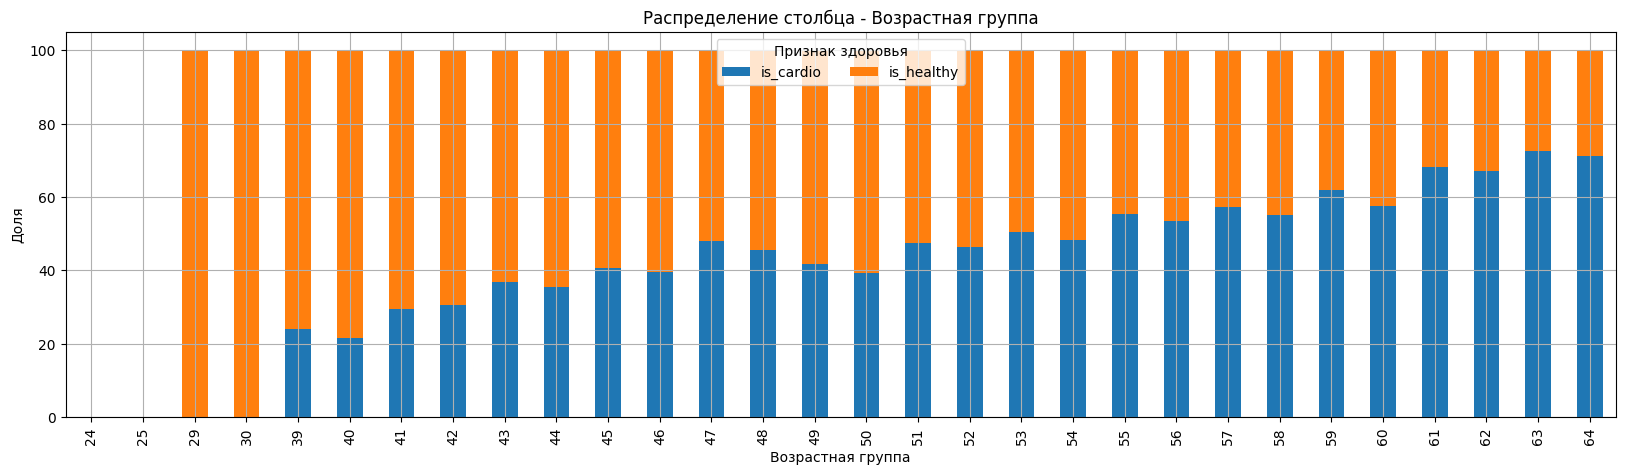

In [49]:
graf_bar(df, 'age', 'Возрастная группа')

Удалять выбросы с возрастом до 35 лет не будем, т. к. судя по графику (столбики 24 и 25) они присутствуют и в тестовой выборки.

**Вывод**: основную доля людей находится в возрасте от 40 до 65. Чем выше возраст, тем выше риск заболевания ССЗ.

#### Давление

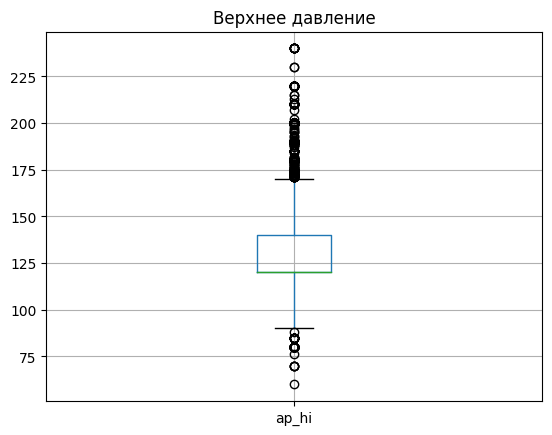

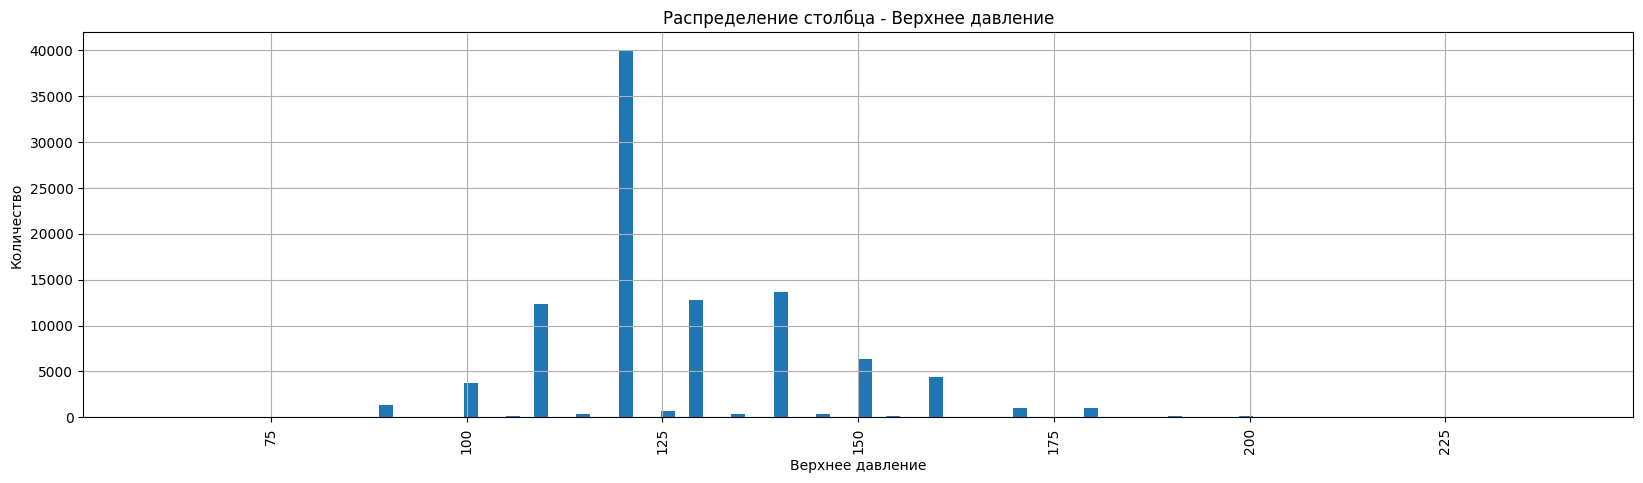

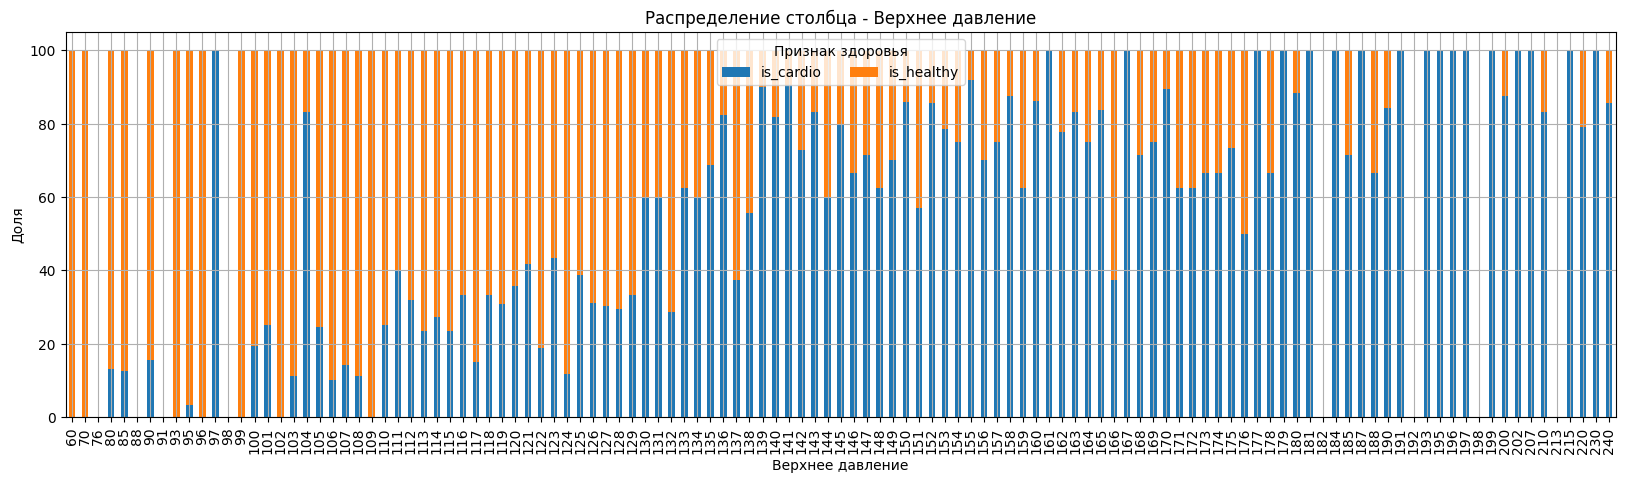

In [50]:
df.boxplot('ap_hi')
plt.title('Верхнее давление')
plt.show()

graf_hist(df, 'ap_hi', 'Верхнее давление')
graf_bar(df, 'ap_hi', 'Верхнее давление')

**Вывод**: чем давление выше, тем риск ССЗ выше

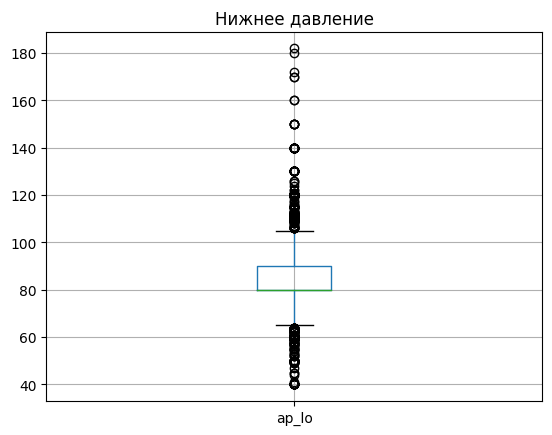

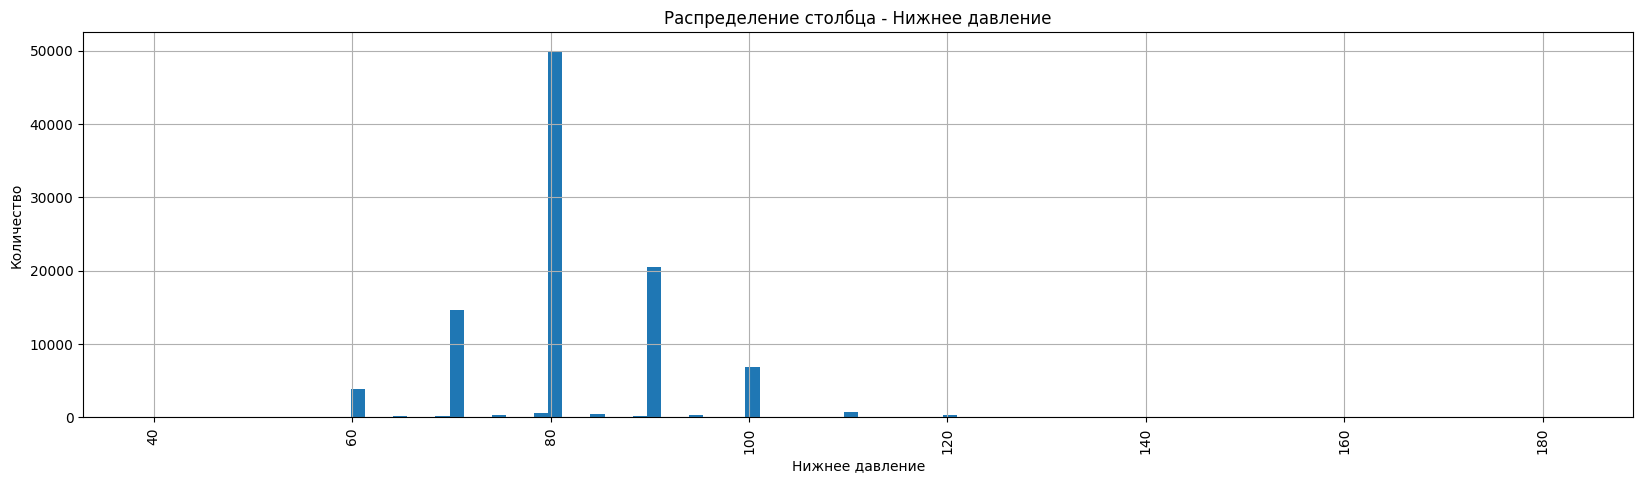

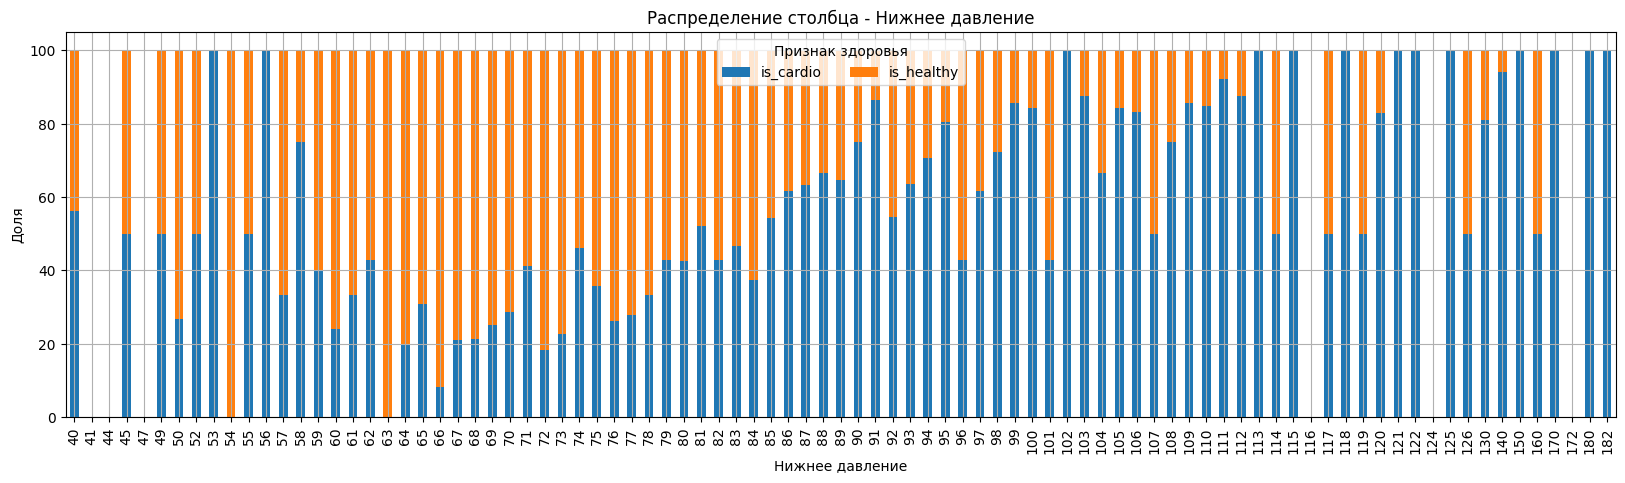

In [51]:
df.boxplot('ap_lo')
plt.title('Нижнее давление')
plt.show()


graf_hist(df, 'ap_lo', 'Нижнее давление')
graf_bar(df, 'ap_lo', 'Нижнее давление')

**Вывод**: чем давление выше, тем риск ССЗ выше, и наоборот при  давлении ниже 60 риск повышается.

#### is_male

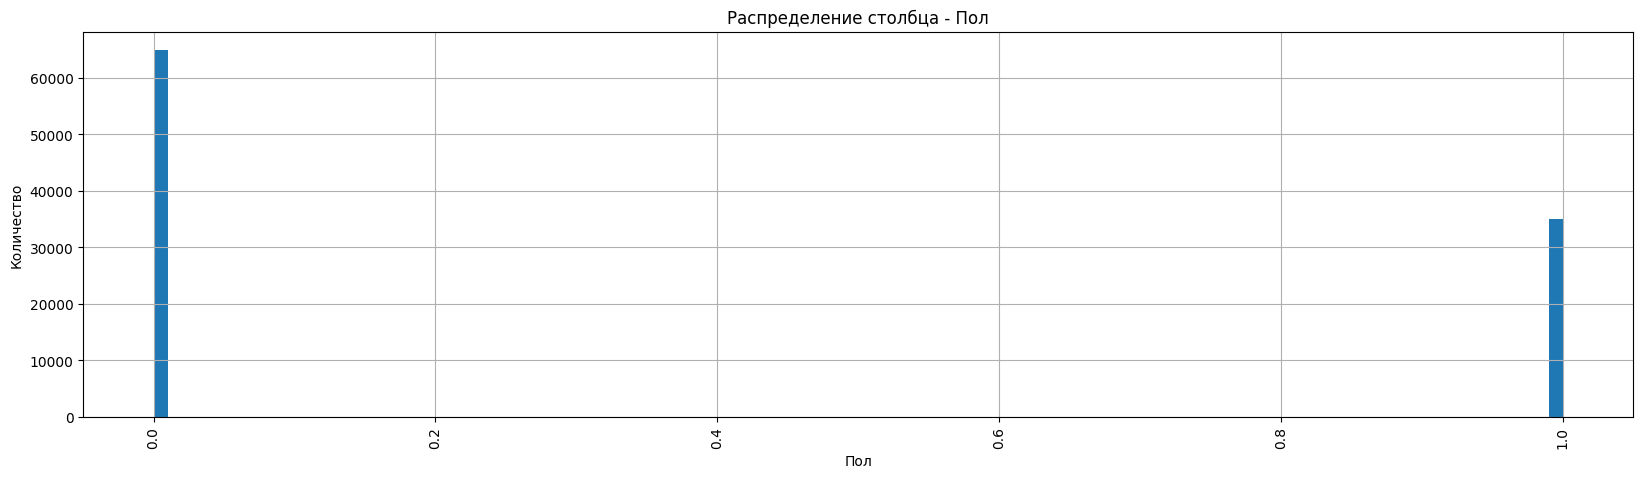

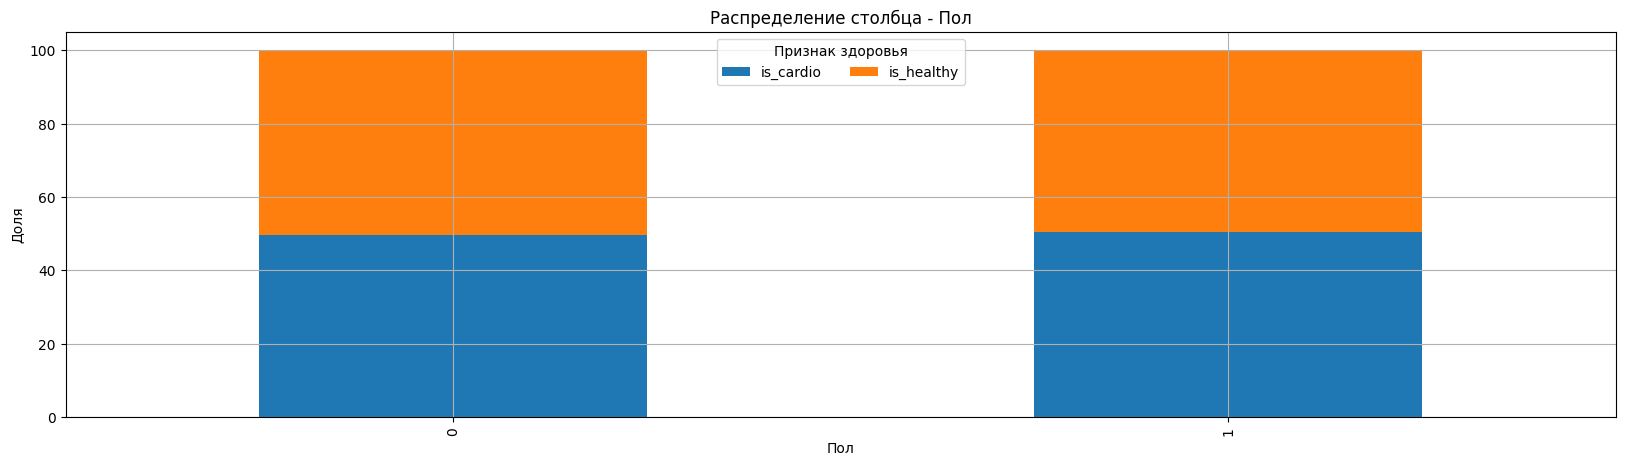

In [52]:
graf_hist(df, 'is_male', 'Пол')
graf_bar(df, 'is_male', 'Пол')

**Вывод**: пол со значением 0 больше, чем 1. Риск заболеваний ССЗ одинаковый. При обучении не будем учитывать этот признак

#### height и weight

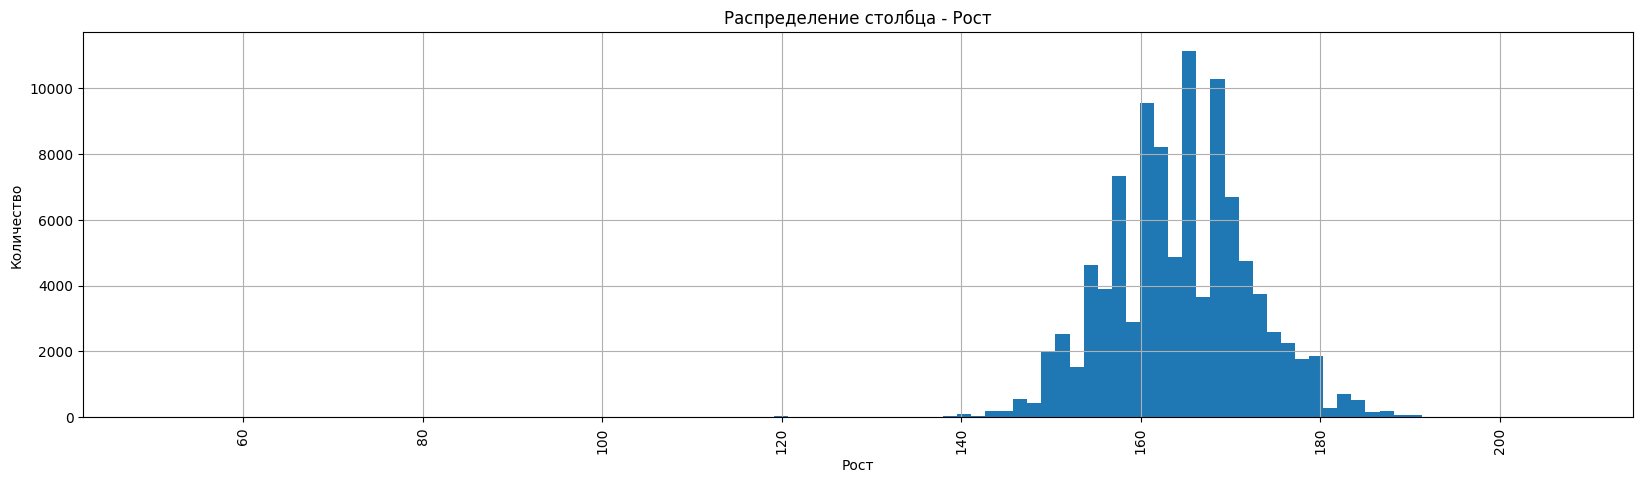

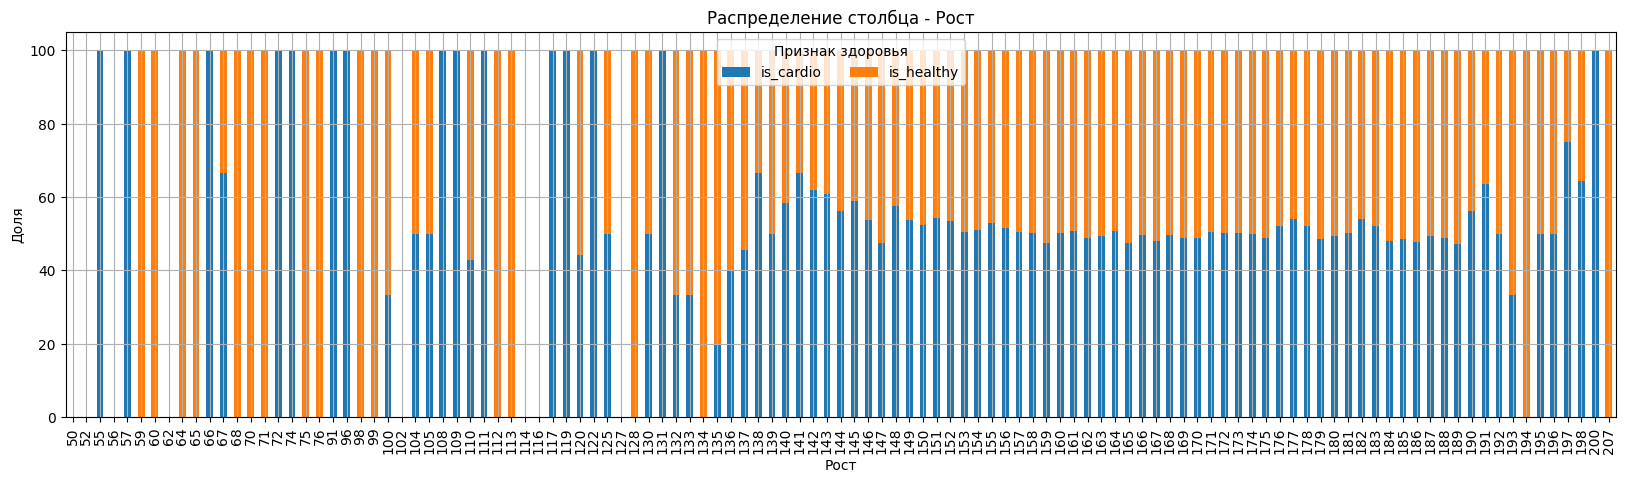

In [53]:
graf_hist(df, 'height', 'Рост')
graf_bar(df, 'height', 'Рост')

**Вывод**: Рост незначительно влияет на целевой признак. При этом при аномально низких и высоких показателей роста, риск ССЗ повышается.

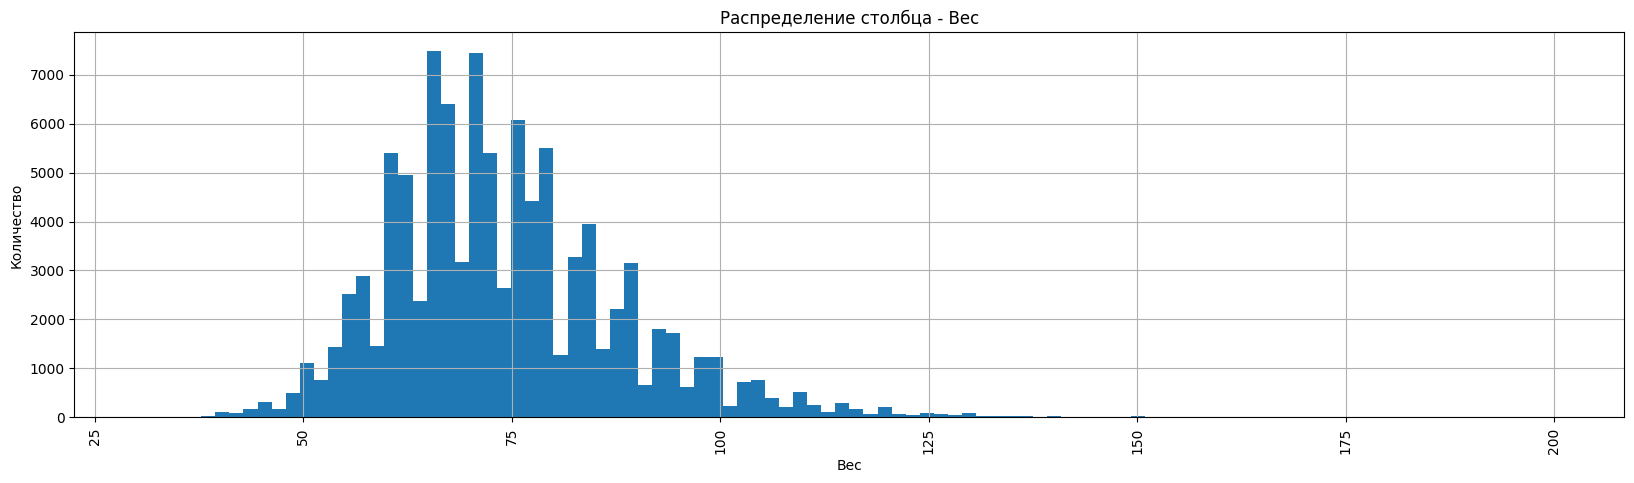

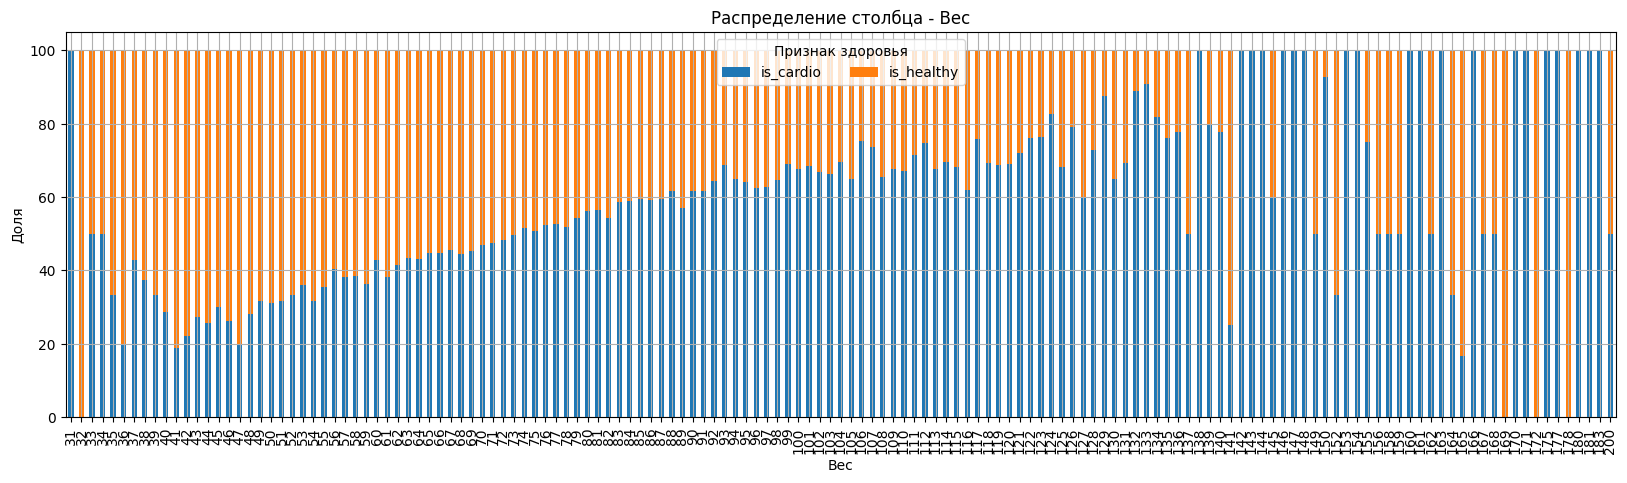

In [54]:
graf_hist(df, 'weight', 'Вес')
graf_bar(df, 'weight', 'Вес')

**Вывод**: если рост отклоняется от среднего, то риск выше. Если вес большой, то риск ССЗ тоже высок.

#### cholesterol

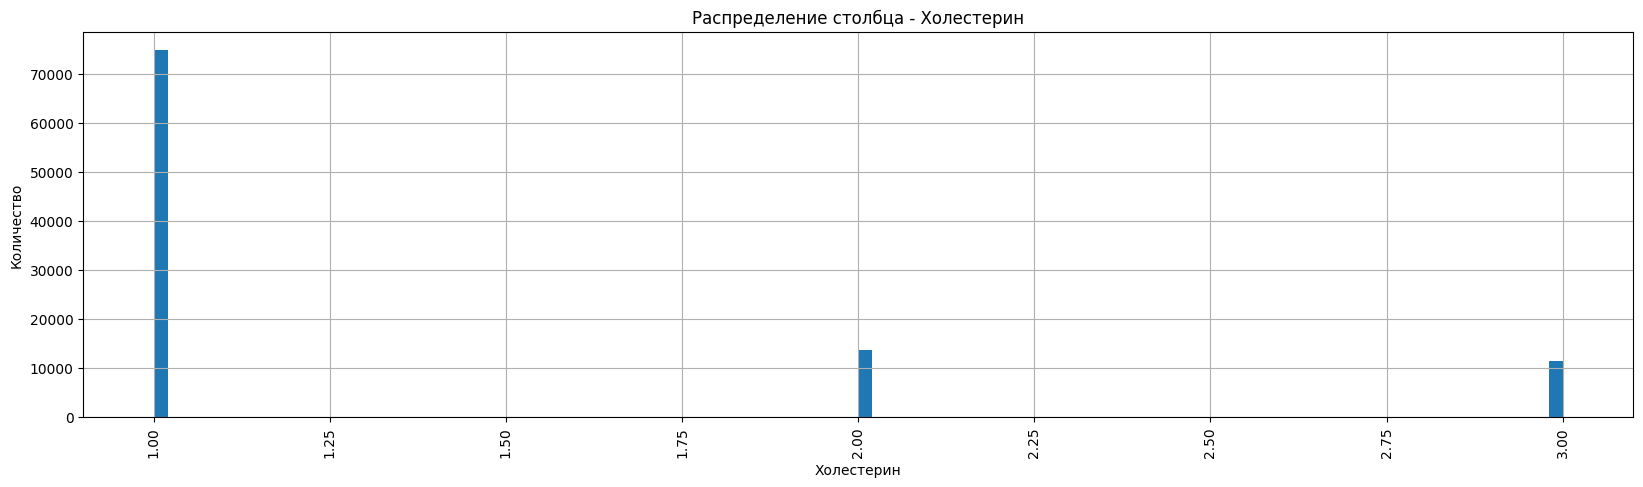

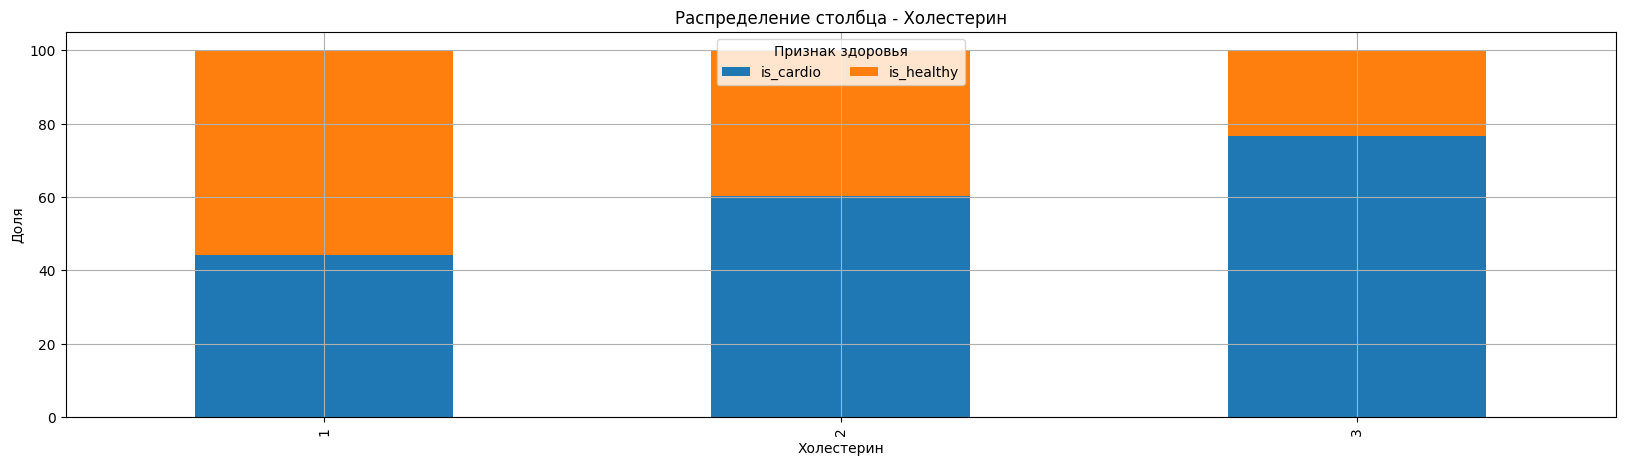

In [55]:
graf_hist(df, 'cholesterol', 'Холестерин')
graf_bar(df, 'cholesterol', 'Холестерин')

**Вывод**: чем выше холестерин, тем риск ССЗ выше.

#### gluc

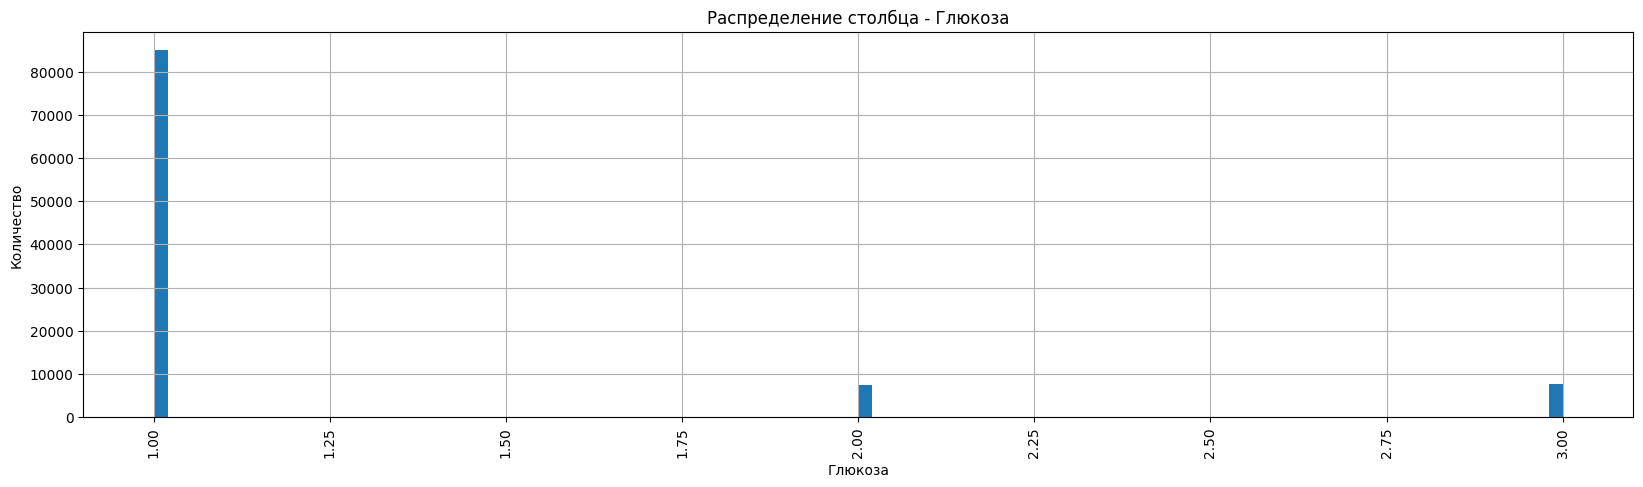

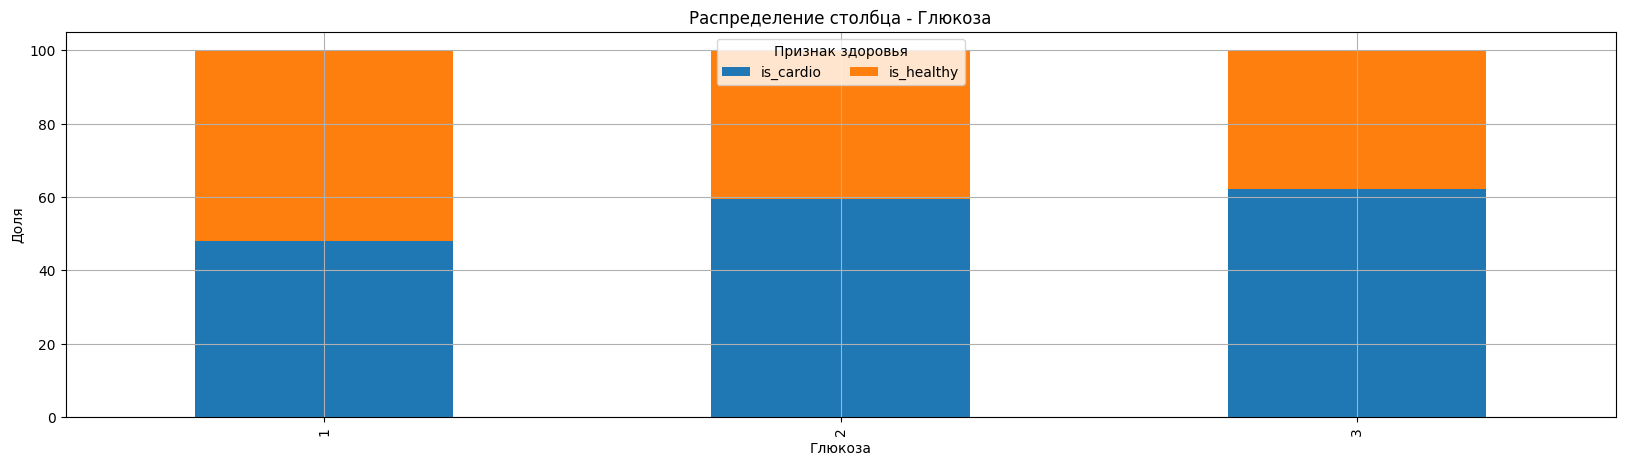

In [56]:
graf_hist(df, 'gluc', 'Глюкоза')
graf_bar(df, 'gluc', 'Глюкоза')

**Вывод**: чем выше глюкоза, тем риск ССЗ выше.

#### smoke

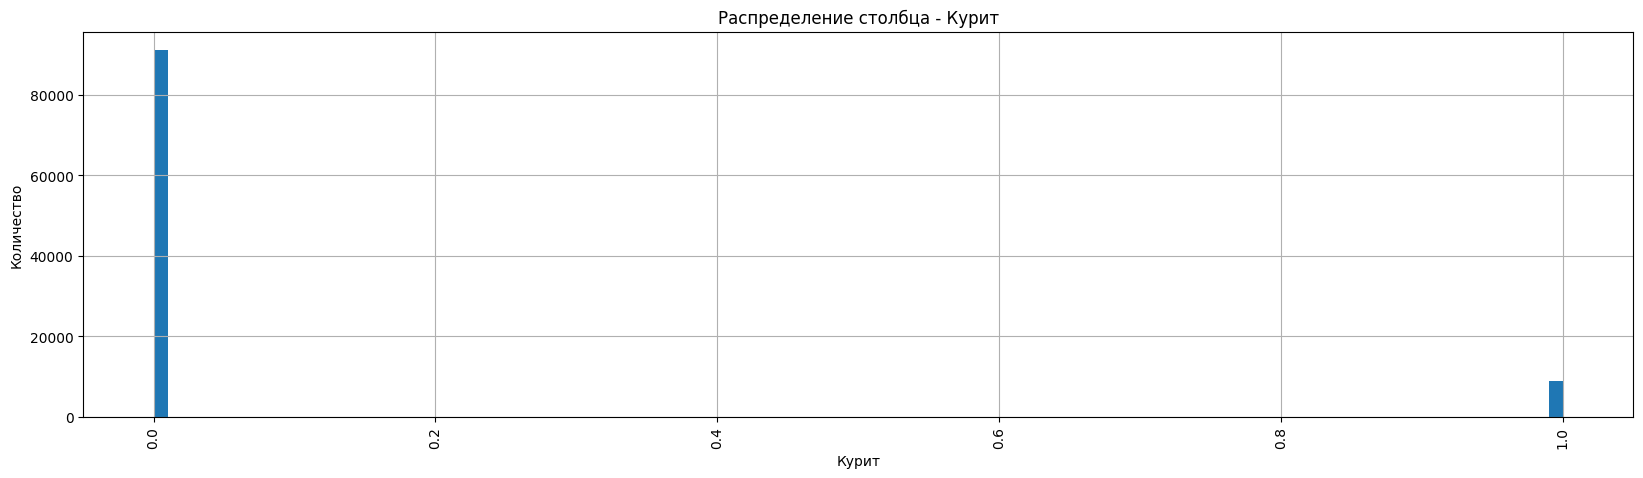

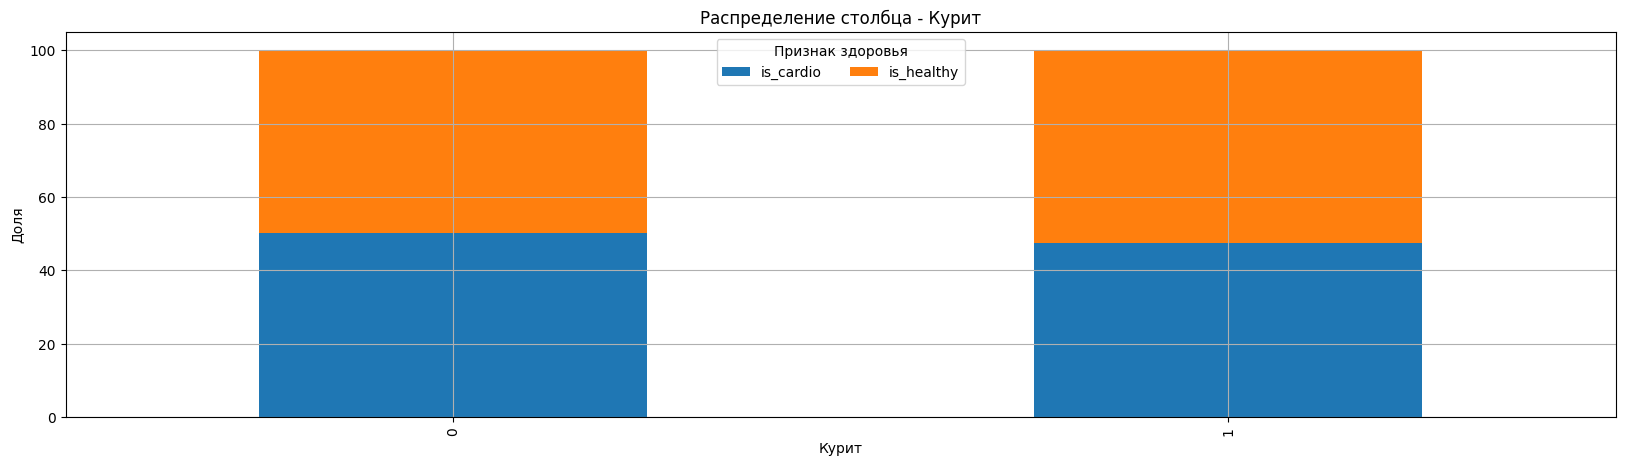

In [57]:
graf_hist(df, 'is_smoke', 'Курит')
graf_bar(df, 'is_smoke', 'Курит')

**Вывод**: странно, но курение не повышает риск ССЗ

#### is_alco

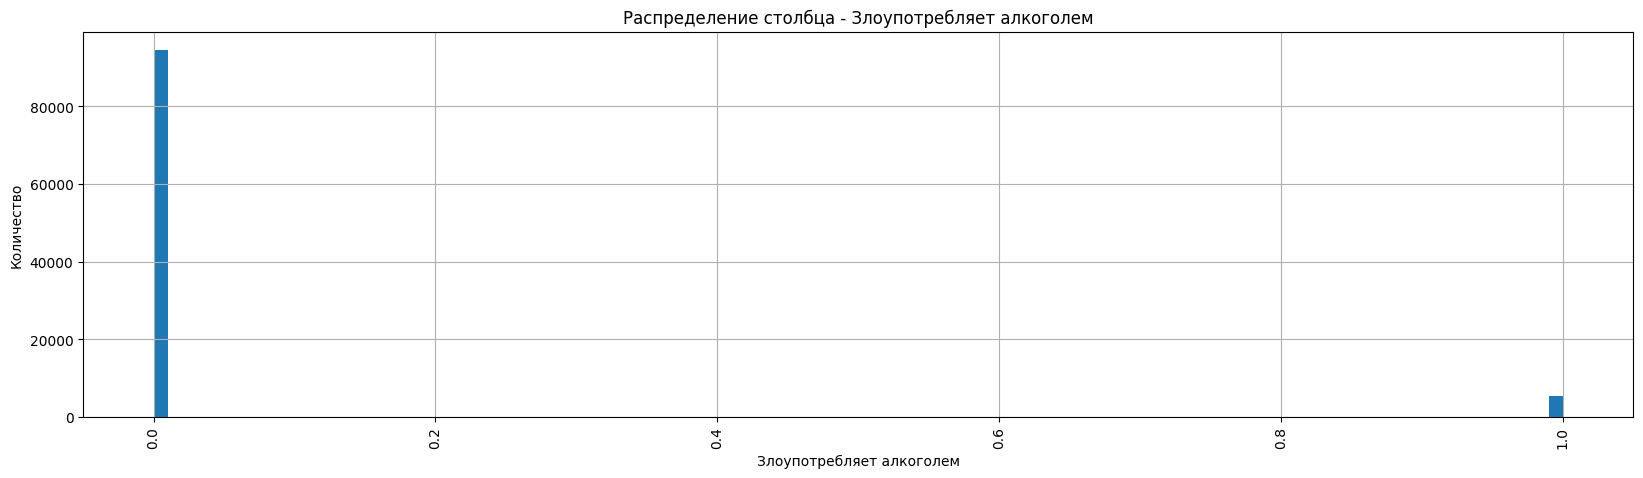

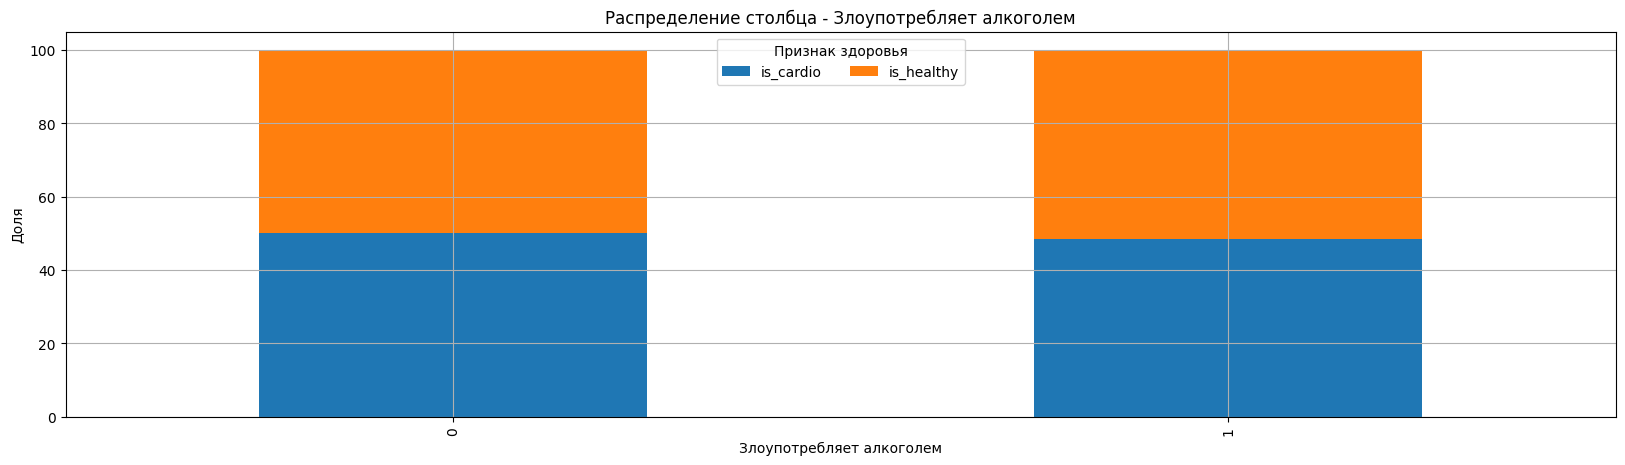

In [58]:
graf_hist(df, 'is_alco', 'Злоупотребляет алкоголем')
graf_bar(df, 'is_alco', 'Злоупотребляет алкоголем')

**Вывод**: аналогично с курением

#### is_active

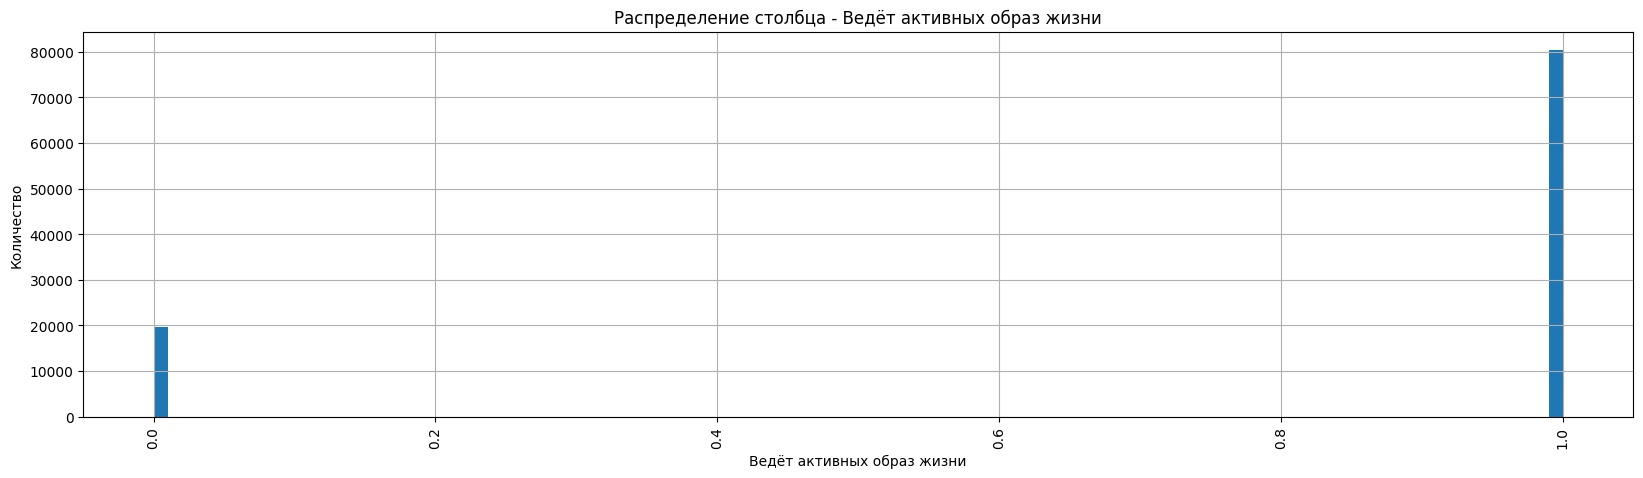

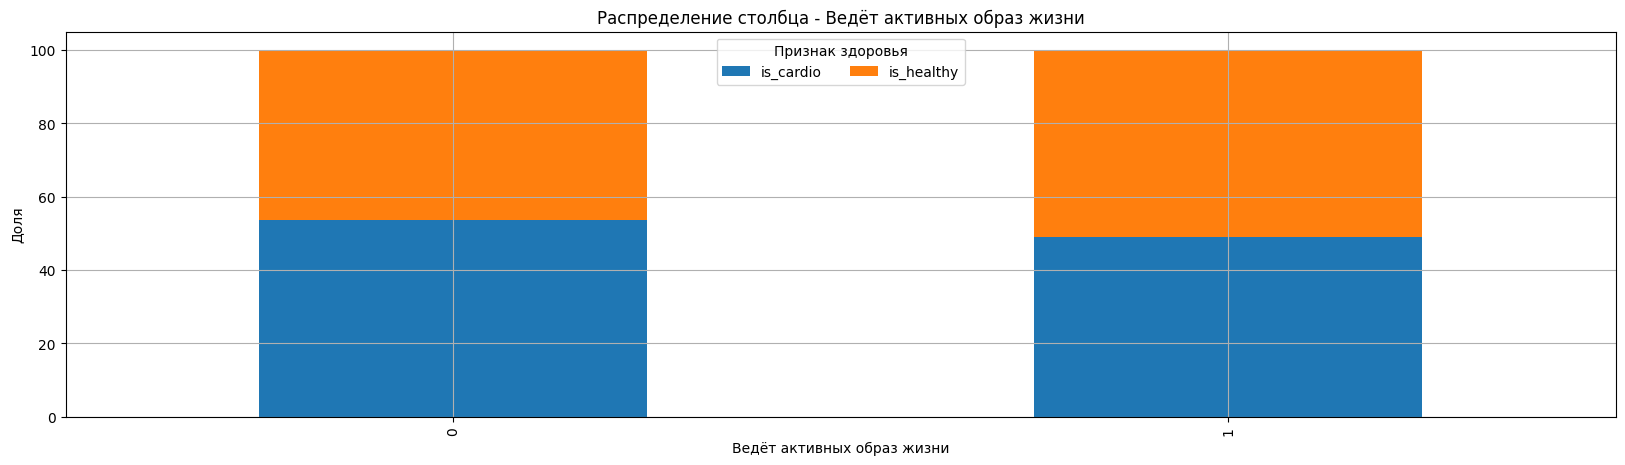

In [59]:
graf_hist(df, 'is_active', 'Ведёт активных образ жизни')
graf_bar(df, 'is_active', 'Ведёт активных образ жизни')

**Вывод**: занятие спортом незначительно снижает риск ССЗ

#### is_cardio

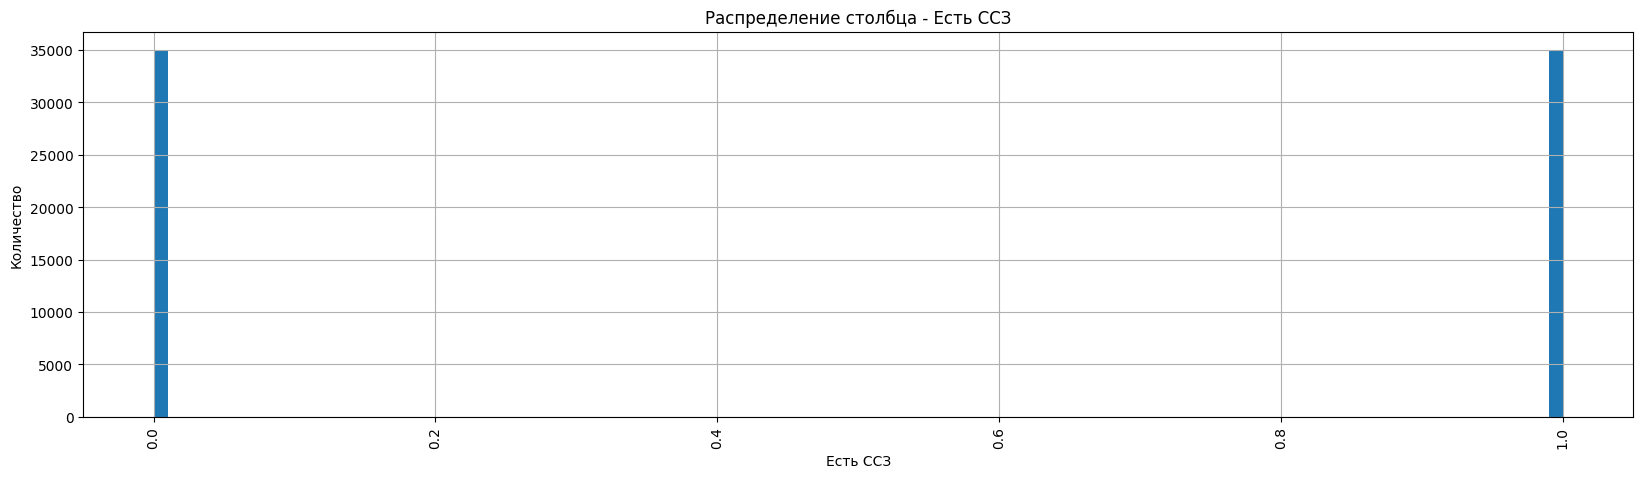

In [60]:
graf_hist(df, 'is_cardio', 'Есть ССЗ')

**Вывод**: дисбаланса нет

### ML

Построим три модели и найдём лучшую:

* DecisionTreeClassifier - дерево решений
* RandomForestClassifier - случайный лес
* LogisticRegression - логистическая регрессия

In [61]:
# создаём вспомогательные методы для хранения лучших метрик
dict_score = {} # переменная для хранения метрик

def best_score(classifier_name, score, method):
    """
    Сохранение лучшей метрики для метода
    
    Параметры:
    ----------
    classifier_name: string - имя классификатора
    score: float - значение метрики
    method: string - метод или группа в рамках, которой производится вычисление 
    """
    item = dict_score.get(method)

    if item:
        if score > item[1]:
            dict_score[method] = [classifier_name, score]
    else:
        dict_score[method] = [classifier_name, score]
        
def get_best_score(method):
    """
    Получение лучшей метрики метода
    
    Параметры:
    ----------
    method: string - метод или группа в рамках, которой производится вычисление 
    
    Результаты
    ----------
    classifier_name: string - имя классификатора
    score: float - значение метрики
    """
    item = dict_score.get(method)
    if item:
        return item[0], item[1]
    else:
        return 'unknown', 0.0

def info_best_score(method):
    """
    Вывод информации о наилучшей метрики
    
    Параметры:
    ----------
    method: string - метод или группа в рамках, которой производится вычисление 
    """
    classifier_name, score = get_best_score(method) 
    print(f'Вывод: наилучшую метрику AUC-ROC показал классификатор {classifier_name} со значением {round(score, 3)}')

In [62]:
# создаём вспомогательные методы для анализа качества моделей DecisionTreeClassifier
def decisionTreeClassifierScore(features_train, target_train, features_valid, target_valid, max_depth=20, depth_step=1):
    """Поиск оптимального качества модели DecisionTreeClassifier
    
    Параметры:
    ----------
    features_train: DataFrame - обучающая выборка
    target_train: DataFrame - целевой признак обучающей выборки
    features_valid: DataFrame - валидационная выборка
    target_valid: DataFrame - целевой признак валидационной выборки
    max_depth: int, default=20 - глубина обучения
    depth_step: int - шаг
    
    Результаты
    ----------
    best_auc_roc_score: array - метрика AUC-ROC
    chart_data: array - данные для построения графика
    """

    best_auc_roc_score = [0, 0] # AUC-ROC и Глубина
    chart_data = []
    with tqdm(total=int(max_depth / depth_step) - 1) as pbar:
        for depth in range(1, max_depth, depth_step):
            model = DecisionTreeClassifier(random_state=12345, max_depth=depth)
            model.fit(features_train, target_train)

            probabilities_valid = model.predict_proba(features_valid)
            auc_roc = roc_auc_score(target_valid, probabilities_valid[:, 1])

            chart_data.append([depth, auc_roc])

            if auc_roc > best_auc_roc_score[0]:
                best_auc_roc_score = [auc_roc, depth]
                
            pbar.update(1)
            
    return best_auc_roc_score, chart_data

def decisionTreeClassifierChart(data):
    """Построение визуального графика для просмотра качества модели DecisionTreeClassifier
    
    Параметры:
    ----------
    data: array - массив данных из трёх колонок: max_depth, AUC-ROC
    """
    
    df = pd.DataFrame(data, columns=['max_depth', 'auc_roc'])
    plt.title('Распределение метрик качества')
    plt.xlabel('Глубина обучения')
    plt.ylabel('Значение метрики')
    plt.plot(df['max_depth'], df['auc_roc'], label = "AUC-ROC")
    plt.legend()
    plt.show()

def decisionTreeClassifierInfo(auc_roc_score):
    """Вывод
    
    Параметры:
    ----------
    auc_roc_score: array - показатели для AUC-ROC 
    """
    print(f'''Для классификатора DecisionTreeClassifier:
 - лучшее качество AUC-ROC равно {round(auc_roc_score[0], 3)}, которое было найдено при гиперпараметре max_depth равном {auc_roc_score[1]}.''')

In [63]:
# создаём вспомогательные методы для анализа качества моделей RandomForestClassifier

def randomForestClassifierScore(features_train, target_train, features_valid, target_valid, max_depth=10, n_estimators=30, step=2):
    """Поиск оптимального качества модели RandomForestClassifier
    
    Параметры:
    ----------
    features_train: DataFrame - обучающая выборка
    target_train: DataFrame - целевой признак обучающей выборки
    features_valid: DataFrame - валидационная выборка
    target_valid: DataFrame - целевой признак валидационной выборки
    max_depth: int, default=10 - глубина обучения
    n_estimators: int, default=30 - количество лесов
    step: int - шаг
    
    Результаты
    ----------
    best_auc_roc_score: array - метрика AUC-ROC
    auc_roc_chart_data: array - данные для построения графика по метрике AUC-ROC
    """
    
    best_auc_roc_score = [0, 0, 0] # AUC-ROC, Глубина и леса
    auc_roc_chart_data = []
    
    estimators_len = int(n_estimators / step) - 1
    if estimators_len <= 0:
        estimators_len = 1
    
    with tqdm(total=estimators_len * (int(max_depth / step) - 1)) as pbar:
        for est in reversed(range(1, n_estimators, step)):
            auc_roc_data = []

            for depth in range(1, max_depth, step):
                model = RandomForestClassifier(random_state=12345, n_estimators=est, max_depth=depth)
                model.fit(features_train, target_train)

                probabilities_valid = model.predict_proba(features_valid)
                auc_roc = roc_auc_score(target_valid, probabilities_valid[:, 1])

                if auc_roc > best_auc_roc_score[0]:
                    best_auc_roc_score = [auc_roc, depth, est]

                auc_roc_data.append(auc_roc)
                
                pbar.update(1)

            auc_roc_chart_data.append(auc_roc_data)

    return best_auc_roc_score, auc_roc_chart_data

def randomForestClassifierChart(auc_roc_data, max_depth=10, n_estimators=30, step=2):
    """Построение визуального графика для просмотра качества модели RandomForestClassifier
    
    Параметры:
    ----------
    auc_roc_data: array - массив данных для метрики AUC-ROC
    """
    
    fig, axs = plt.subplots(figsize=(20, 6)) 

    df = pd.DataFrame(auc_roc_data, index=list(reversed(range(1, n_estimators, step))), columns=list(range(1, max_depth, step)))
    sbn.heatmap(df, ax=axs)
    axs.set_title('Распределение метрики AUC-ROC')
    axs.set_xlabel('Глубина обучения')
    axs.set_ylabel('Количество деревьев')

    plt.show()

def randomForestClassifierInfo(auc_roc_score):
    """Вывод для модели RandomForestClassifier
    
    Параметры:
    ----------
    auc_roc_score: array - показатели для AUC-ROC 
    """
    print(f'''Для классификатора RandomForestClassifier:
 - лучшее качество AUC-ROC равно {round(auc_roc_score[0], 3)}, которое было найдено при гиперпараметрах n_estimators равном {round(auc_roc_score[2], 3)} и max_depth равном {auc_roc_score[1]}.''')

In [64]:
# создаём вспомогательные методы для анализа качества моделей LogisticRegression

def logisticRegressionScore(features_train, target_train, features_valid, target_valid, max_iter=1000):
    """Поиск оптимального качества модели LogisticRegression
    
    Параметры:
    ----------
    features_train: DataFrame - обучающая выборка
    target_train: DataFrame - целевой признак обучающей выборки
    features_valid: DataFrame - валидационная выборка
    target_valid: DataFrame - целевой признак валидационной выборки
    
    Результаты
    ----------
    best_auc_roc_score: int - метрика AUC-ROC
    """
    
    best_auc_roc_score = 0 # AUC-ROC
    
    model = LogisticRegression(random_state=12345, solver='liblinear', max_iter=max_iter)
    model.fit(features_train, target_train)

    probabilities_valid = model.predict_proba(features_valid)
    best_auc_roc_score = roc_auc_score(target_valid, probabilities_valid[:, 1])

    return best_auc_roc_score

def logisticRegressionInfo(auc_roc_score):
    """Вывод для модели LogisticRegression
    
    Параметры:
    ----------
    auc_roc_score: array - показатели для AUC-ROC 
    """
    print(f'''Для классификатора LogisticRegression:
 - лучшее качество AUC-ROC равно {round(auc_roc_score, 3)}.''')

In [65]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99975 entries, 0 to 99997
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   age          99975 non-null  int8   
 1   is_male      99975 non-null  int8   
 2   height       99975 non-null  int16  
 3   weight       99975 non-null  int16  
 4   ap_hi        99975 non-null  int16  
 5   ap_lo        99975 non-null  int16  
 6   cholesterol  99975 non-null  int8   
 7   gluc         99975 non-null  int8   
 8   is_smoke     99975 non-null  int8   
 9   is_alco      99975 non-null  int8   
 10  is_active    99975 non-null  int8   
 11  is_cardio    69975 non-null  float32
 12  is_train     99975 non-null  int8   
 13  is_healthy   69975 non-null  float32
dtypes: float32(2), int16(4), int8(8)
memory usage: 5.1 MB


In [66]:
# разделим выборки
df_train = df.loc[df['is_train'] == 1]
df_test = df.loc[df['is_train'] == 0]

In [67]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 69975 entries, 0 to 99999
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   age          69975 non-null  int8   
 1   is_male      69975 non-null  int8   
 2   height       69975 non-null  int16  
 3   weight       69975 non-null  int16  
 4   ap_hi        69975 non-null  int16  
 5   ap_lo        69975 non-null  int16  
 6   cholesterol  69975 non-null  int8   
 7   gluc         69975 non-null  int8   
 8   is_smoke     69975 non-null  int8   
 9   is_alco      69975 non-null  int8   
 10  is_active    69975 non-null  int8   
 11  is_cardio    69975 non-null  float32
 12  is_train     69975 non-null  int8   
 13  is_healthy   69975 non-null  float32
dtypes: float32(2), int16(4), int8(8)
memory usage: 2.1 MB


In [68]:
df_train.head()

,age,is_male,height,weight,ap_hi,ap_lo,cholesterol,gluc,is_smoke,is_alco,is_active,is_cardio,is_train,is_healthy
id,,,,,,,,,,,,,,
0,50,1,168,62,110,80,1,1,0,0,1,0.0,1,1.0
1,55,0,156,85,140,90,3,1,0,0,1,1.0,1,0.0
2,51,0,165,64,130,70,3,1,0,0,0,1.0,1,0.0
3,48,1,169,82,150,100,1,1,0,0,1,1.0,1,0.0
4,47,0,156,56,100,60,1,1,0,0,0,0.0,1,1.0


In [69]:
df_train.corr()

,age,is_male,height,weight,ap_hi,ap_lo,cholesterol,gluc,is_smoke,is_alco,is_active,is_cardio,is_train,is_healthy
age,1.000000,-0.022706,-0.082212,0.053943,0.206028,0.154021,0.153989,0.098536,-0.047493,-0.029683,-0.009802,0.237973,NaN,-0.237973
is_male,-0.022706,1.000000,0.500812,0.155861,0.062681,0.067862,-0.035891,-0.020562,0.338130,0.170948,0.005922,0.008048,NaN,-0.008048
height,-0.082212,0.500812,1.000000,0.295877,0.017220,0.034156,-0.050583,-0.018236,0.189561,0.094658,-0.006373,-0.010730,NaN,0.010730
weight,0.053943,0.155861,0.295877,1.000000,0.272964,0.256781,0.141868,0.106737,0.067391,0.067366,-0.016830,0.181815,NaN,-0.181815
ap_hi,0.206028,0.062681,0.017220,0.272964,1.000000,0.743018,0.196005,0.094352,0.028331,0.036059,0.001264,0.431010,NaN,-0.431010
ap_lo,0.154021,0.067862,0.034156,0.256781,0.743018,1.000000,0.161998,0.073879,0.026294,0.037887,0.001837,0.346565,NaN,-0.346565
cholesterol,0.153989,-0.035891,-0.050583,0.141868,0.196005,0.161998,1.000000,0.451572,0.010309,0.035728,0.009911,0.221096,NaN,-0.221096
gluc,0.098536,-0.020562,-0.018236,0.106737,0.094352,0.073879,0.451572,1.000000,-0.004801,0.011212,-0.006758,0.089275,NaN,-0.089275
is_smoke,-0.047493,0.338130,0.189561,0.067391,0.028331,0.026294,0.010309,-0.004801,1.000000,0.340077,0.025873,-0.015529,NaN,0.015529
is_alco,-0.029683,0.170948,0.094658,0.067366,0.036059,0.037887,0.035728,0.011212,0.340077,1.000000,0.025488,-0.007362,NaN,0.007362


In [70]:
drop_columns = ['is_train', 'is_healthy', 'is_cardio']

In [71]:
features = df_train.drop(drop_columns, axis=1)
target = df_train['is_cardio']   

In [72]:
features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 69975 entries, 0 to 99999
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   age          69975 non-null  int8 
 1   is_male      69975 non-null  int8 
 2   height       69975 non-null  int16
 3   weight       69975 non-null  int16
 4   ap_hi        69975 non-null  int16
 5   ap_lo        69975 non-null  int16
 6   cholesterol  69975 non-null  int8 
 7   gluc         69975 non-null  int8 
 8   is_smoke     69975 non-null  int8 
 9   is_alco      69975 non-null  int8 
 10  is_active    69975 non-null  int8 
dtypes: int16(4), int8(7)
memory usage: 1.5 MB


In [73]:
# делим для валидации
features_train, features_valid, target_train, target_valid = train_test_split(features, target, test_size=0.4, random_state=12345)
# делим для тестирования 
features_valid, features_test, target_valid, target_test = train_test_split(features_valid, target_valid, test_size=0.5, random_state=12345)


DecisionTreeClassifier


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:01<00:00, 14.44it/s]


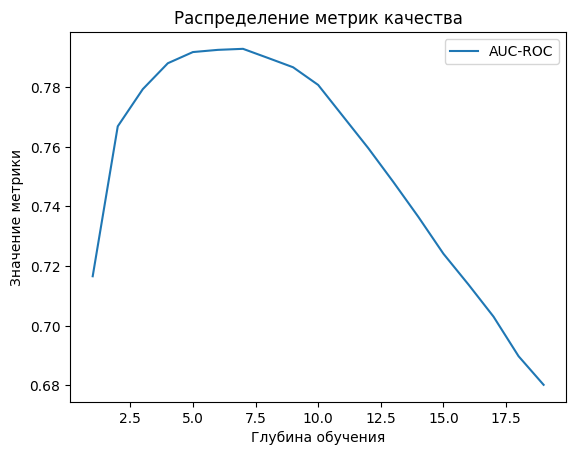

Для классификатора DecisionTreeClassifier:
 - лучшее качество AUC-ROC равно 0.793, которое было найдено при гиперпараметре max_depth равном 7.

RandomForestClassifier


100%|████████████████████████████████████████████████████████████████████████████████| 162/162 [00:18<00:00,  8.72it/s]


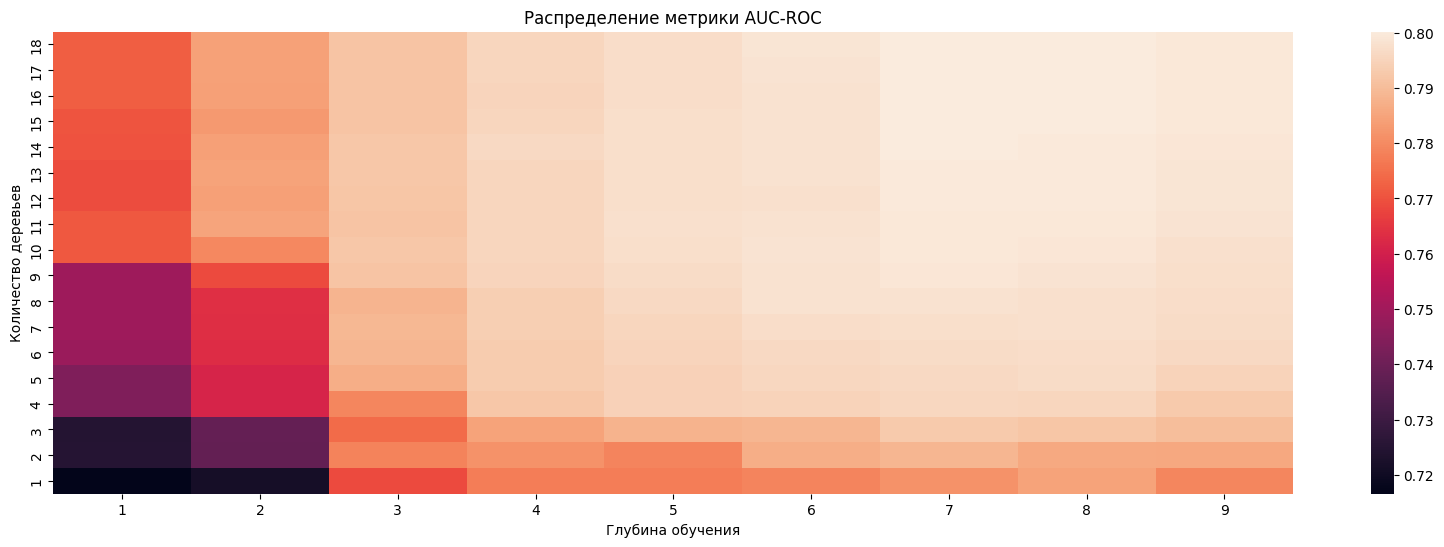

Для классификатора RandomForestClassifier:
 - лучшее качество AUC-ROC равно 0.8, которое было найдено при гиперпараметрах n_estimators равном 16 и max_depth равном 8.

LogisticRegression
Для классификатора LogisticRegression:
 - лучшее качество AUC-ROC равно 0.792.


Вывод: наилучшую метрику AUC-ROC показал классификатор RandomForestClassifier со значением 0.8


In [74]:
print('\nDecisionTreeClassifier')

# используем созданный ранее метод
dtc_best_auc_roc_score, chart_data = decisionTreeClassifierScore(features_train, target_train, features_valid, target_valid, max_depth=20, depth_step=1)
# строим график
decisionTreeClassifierChart(chart_data)


# сохраняем лучший результат
best_score('DecisionTreeClassifier', dtc_best_auc_roc_score[0], 'Базовый')
# вывод информации
decisionTreeClassifierInfo(dtc_best_auc_roc_score)

print('\nRandomForestClassifier')

# используем созданный ранее метод
rfc_best_auc_roc_score, auc_roc_chart_data = randomForestClassifierScore(features_train, target_train, features_valid, target_valid, max_depth=10, n_estimators=19, step=1)
# строим график
randomForestClassifierChart(auc_roc_chart_data, max_depth=10, n_estimators=19, step=1)

# сохраняем лучший результат
best_score('RandomForestClassifier', rfc_best_auc_roc_score[0], 'Базовый')
# вывод информации
randomForestClassifierInfo(rfc_best_auc_roc_score)

print('\nLogisticRegression')

scaler = StandardScaler()
features_train_ss = features_train.copy()
features_valid_ss = features_valid.copy()

scale_columns = ['age', 'weight', 'height', 'ap_hi', 'ap_lo', 'gluc', 'cholesterol']

scaler.fit(features_train_ss.loc[:, scale_columns])
features_train_ss[scale_columns] = scaler.transform(features_train_ss[scale_columns])
features_valid_ss[scale_columns] = scaler.transform(features_valid_ss[scale_columns])

lr_best_auc_roc_score = logisticRegressionScore(features_train_ss, target_train, features_valid_ss, target_valid)

# сохраняем лучший результат
best_score('LogisticRegression', lr_best_auc_roc_score, 'Базовый')
# вывод информации
logisticRegressionInfo(lr_best_auc_roc_score)

print('\n')
info_best_score('Базовый') 

#### Тестирование модели

In [75]:
# получаем лучшую метрику
best_method = 'unknown'
best_classifier = 'unknown'
best_score_method = 0

for method in dict_score:
    item = get_best_score(method)
    if item[1] > best_score_method:
        best_score_method = item[1]
        best_classifier = item[0]
        best_method = method
        
print(f'Лучшую метрику ROC-AUC {round(best_score_method, 3)} показал метод "{best_method}" с классификатором {best_classifier}.')

Лучшую метрику ROC-AUC 0.8 показал метод "Базовый" с классификатором RandomForestClassifier.


In [76]:
MAX_DEPTH=8
N_ESTIMATORS=16

In [77]:
model = RandomForestClassifier(random_state=12345, max_depth=MAX_DEPTH, n_estimators=N_ESTIMATORS)
model.fit(features_train, target_train)

probabilities_valid = model.predict_proba(features_test)
auc_roc = roc_auc_score(target_test, probabilities_valid[:, 1])

print(f'AUC-ROC =', auc_roc)

print(classification_report(target_test, model.predict(features_test)))

AUC-ROC = 0.7981653479442725
              precision    recall  f1-score   support

         0.0       0.72      0.79      0.75      7052
         1.0       0.76      0.68      0.72      6943

    accuracy                           0.74     13995
   macro avg       0.74      0.73      0.73     13995
weighted avg       0.74      0.74      0.73     13995



In [78]:
# обучим на всей выборке
features = df_train.drop(drop_columns, axis=1)
target = df_train['is_cardio']

cls = RandomForestClassifier(random_state=12345, max_depth=MAX_DEPTH, n_estimators=N_ESTIMATORS)
cls.fit(features, target)

RandomForestClassifier(max_depth=8, n_estimators=16, random_state=12345)

In [79]:
features = df_test.drop(drop_columns, axis=1)

probabilities_valid = cls.predict_proba(features)

to_submit = pd.DataFrame(index=df_test.index)
to_submit['cardio'] = probabilities_valid[:, 1]
to_submit['cardio'] = to_submit['cardio'].astype('float16')
to_submit.to_csv('submission.csv')
print(to_submit.shape)

dump(cls, 'heart.model')

(30000, 1)


['heart.model']

In [80]:
to_submit.head()

,cardio
id,
5,0.535156
6,0.587891
7,0.401367
10,0.536133
11,0.235474
